---
---
# Strategic Growth Analysis
---
---
## Comprehensive Business Intelligence for Unique Gifts Ltd.

**Project Overview:**
This notebook contains a comprehensive analysis of transactional data from Unique Gifts Ltd., a UK-based online retailer. The analysis follows a structured approach to provide data-driven strategic insights and recommendations.

**Business Objectives:**
1. Sales Performance & Seasonality Analysis
2. Product Portfolio Optimization
3. Geographic Market Analysis
4. Customer Segmentation using RFM Analysis
5. Wholesaler vs. Retail Customer Analysis
6. Data Enrichment via API Integration

---

## Setup and Data Loading

In [172]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
from datetime import datetime, timedelta
from typing import Tuple
import json
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set Seaborn styling
sns.set(style='whitegrid', palette='pastel')

# Set display options
pd.set_option('display.max_columns', None) # Display all columns of the DataFrame without truncation
pd.set_option('display.max_rows', 100) # Display a maximum of 100 rows in the DataFrame

# Set consistent style for all plots
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

All libraries imported successfully!
Analysis Date: 2025-08-30 21:53:32


# Phase 1: Data Sanitation and Preprocessing
---

**Team:** Code Serpents

**Team Member:** S. M. L. Lakshan jayawardhana

---

## Executive Summary

This notebook focuses on cleaning and preparing the raw transactional data for "Unique Gifts Ltd." The preprocessing phase ensures data quality and creates essential features needed for subsequent analysis, transforming messy raw data into a reliable, analysis-ready dataset.

## Objectives

1. **Data Loading**: Ingest the online_retail.csv file into a Pandas DataFrame
2. **Data Assessment**: Conduct preliminary audit to identify data quality issues
3. **Data Cleaning**: Handle duplicates, missing values, and invalid records
4. **Feature Engineering**: Create new columns for temporal analysis and revenue calculation
5. **Data Type Conversion**: Ensure proper data types for all columns

---

### Helper Functions
---

In [173]:
# ================================================================
# 1. Data Loading & Initial Assessment
# ================================================================

def load_data(file_path):
    """Load and preprocess retail data"""
    
    d_types = {
        'Invoice': 'object',
        'StockCode': 'object',
        'Description': 'object',
        'Quantity': 'int64',
        'InvoiceDate': 'object',
        'Price': 'float64',
        'Customer ID': 'float64',
        'Country': 'object'
    }

    try:
        df = pd.read_csv(file_path, dtype=d_types, encoding="ISO-8859-1")
        print(f"Data Loaded successfully! \n {df.head()}")
        return df
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return None
    except ValueError as ve:
        print(f"Data type mismatch : {ve}")
        return None
    except EncodingWarning as ew:
        print(f"Encoding warning : {ew}")
        return None
    except Exception as e:
        print(f"Unexpected error : {e}")
        return None

def assess_data(df):
    """Perform initial data assessment including info, statistics, and missing values"""
    
    if df is None:
        print("No data to assess.")
        return None

    print(f"\n=== DataFrame Information ===")
    print(df.info())
    
    print(f"\n=== Statistical Summary ===")
    print(df.describe(include='all'))
    
    print(f"\n=== Missing Values ===")
    print(df.isnull().sum())
    
    return df


# ================================================================
# 2. Data Cleaning & Quality Control
# ================================================================

def handle_duplicates(df):
    """Identify and remove duplicate rows from the dataset"""
    
    if df is None:
        print(f"No data to handle duplicates.")
        return None

    duplicates_count = df.duplicated().sum()
    print(f"\nNumber of duplicate rows are: {duplicates_count}")
    df = df.drop_duplicates()  
    print(f"Duplicate values removed. New shape is: {df.shape}")
    return df

def handle_missing_customer_id(df):
    """Remove rows with missing Customer ID values"""
    
    if df is None:
        print(f"No data to handle missing Customer ID.")
        return None

    missing_cusid = df['Customer ID'].isnull().sum()
    print(f"Number of rows missing customer id : {missing_cusid}")
    df = df.dropna(subset=['Customer ID'])
    print(f"Remove misssing customer id rows. New shape is : {df.shape}")

    print(df.isnull().sum())
    return df

def remove_cancelled_orders(df):
    """Filter out cancelled orders (invoices starting with 'C')"""
    
    if df is None:
        print("No data to remove cancelled orders.")
        return None

    cancellsd_order_count = df[df['Invoice'].str.startswith('C', na=False)].shape[0]
    print(f"\nNumber of cancelled orders: {cancellsd_order_count}")
    df = df[~df['Invoice'].str.startswith('C', na=False)]
    print(f"Remove cancelled orders. New shape is : {df.shape}")
    return df

def remove_zero_price(df):
    """Remove rows with zero or negative prices"""
    
    if df is None:
        print(f"No data to remove zero price rows.")
        return None

    zero_count = df[df['Price'] == 0].shape[0]
    print(f"\nNumber of zero price rows: {zero_count}")
    df = df[df['Price'] > 0]
    print(f"Zero price rows removed. New shape: {df.shape}")
    return df

def remove_non_product_codes(df):
    """Remove non-product stock codes (postage, bank charges, etc.)"""
    
    if df is None:
        print(f"No data to remove non-product codes.")
        return None

    non_product_codes = ['POST', 'M', 'BANK CHARGES', 'C2', 'DOT', 'CRUK'] 
    non_product_count = df[df['StockCode'].isin(non_product_codes)].shape[0]
    print(f"\nNumber of non product rows: {non_product_count}")
    df = df[~df['StockCode'].isin(non_product_codes)]
    print(f"Non product rows removed. New shape: {df.shape}")
    return df

def remove_negative_quantity(df):
    """Remove rows with negative or zero quantities"""
    
    if df is None:
        print(f"No data to remove negative quantity.")
        return None

    zero_qty = df[df['Quantity'] <= 0].shape[0]
    print(f"\nNumber of negative or zero Quantity: {zero_qty}")
    df = df[df['Quantity'] > 0]
    print(f"Negative or zero quantity rows removed. New shape: {df.shape}")
    return df


# ================================================================
# 3. Feature Engineering
# ================================================================

def add_total_price(df):
    """Create TotalPrice column by multiplying Quantity and Price"""
    
    if df is None:
        print(f"No data to add TotalPrice.")
        return None

    df['TotalPrice'] = df['Quantity'] * df['Price']
    print(f"\nTotalPrice column added. New shape: {df.shape}")
    print(f"{df[['Quantity', 'Price', 'TotalPrice']].head()}")
    return df

def add_date_columns(df):
    """Extract temporal features from InvoiceDate column"""
    
    if df is None:
        print(f"No data to add date columns.")
        return None

    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='ISO8601')
    df['Year'] = df['InvoiceDate'].dt.year
    df['Month'] = df['InvoiceDate'].dt.month
    df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek  
    df['HourOfDay'] = df['InvoiceDate'].dt.hour
    print(f"\nDate columns added. New shape: {df.shape}")
    print(f"{df[['InvoiceDate', 'Year', 'Month', 'DayOfWeek', 'HourOfDay']].head()}")
    return df


# ================================================================
# 4. Data Type Conversion & Final Processing
# ================================================================

def convert_data_types(df):
    """Convert columns to appropriate data types for analysis"""
    
    if df is None:
        print(f"No data to convert types.")
        return None

    df['Customer ID'] = df['Customer ID'].astype(int)
    df['StockCode'] = df['StockCode'].astype(str)
    df['Quantity'] = df['Quantity'].astype(int)
    df['Price'] = df['Price'].astype('float32')
    df['TotalPrice'] = df['TotalPrice'].astype('float32')

    print(f"\nFinal Data Types:")
    print(f"{df.dtypes}")
    print(f"\nFinal Shape: {df.shape}")
    return df

### 1.1 Data Loading and Initial Assessment
---

The first step is to load the raw transactional data into a Pandas DataFrame and conduct an initial assessment to understand the data's structure, statistics, and missing values.

- **Data Types**: The `load_data()` function specifies the correct data types for each column to ensure accurate processing during further steps.
- **Initial Assessment**: The `assess_data()` function provides a quick overview of the data by showing:
  - DataFrame structure using `.info()`
  - Descriptive statistics using `.describe()`
  - Missing values per column using `.isnull().sum()`

In [174]:
df = load_data("../data/online_retail.csv")
df = assess_data(df)

Data Loaded successfully! 
   Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  

=== DataFrame Information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype 

### 1.2 Handling Duplicates
---

The dataset may contain duplicate entries. The `handle_duplicates()` function identifies and removes any duplicate rows, ensuring that each transaction is unique.

In [175]:
df = handle_duplicates(df)


Number of duplicate rows are: 34335
Duplicate values removed. New shape is: (1033036, 8)


### 1.3 Handling Missing Customer IDs
---

Rows with missing `Customer ID` values are critical as they prevent customer-level analysis. The `handle_missing_customer_id()` function removes these rows.

In [176]:
df = handle_missing_customer_id(df)

Number of rows missing customer id : 235151
Remove misssing customer id rows. New shape is : (797885, 8)
Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64


### 1.4 Removing Cancelled Orders
---

Cancelled orders are identified by invoice numbers that start with the letter 'C'. The `remove_cancelled_orders()` function filters these out to focus on actual sales data.

In [177]:
df = remove_cancelled_orders(df)


Number of cancelled orders: 18390
Remove cancelled orders. New shape is : (779495, 8)


### 1.5 Removing Zero or Negative Prices
---

Rows with zero or negative prices are either data entry errors or non-revenue transactions. The `remove_zero_price()` function removes these entries.

In [178]:
df = remove_zero_price(df)


Number of zero price rows: 70
Zero price rows removed. New shape: (779425, 8)


### 1.6  Removing Non-Product Codes
---

Some stock codes may represent non-product items like postage, bank charges, etc. The `remove_non_product_codes()` function filters out these rows to ensure that only actual product transactions remain in the dataset.

In [179]:
df = remove_non_product_codes(df)


Number of non product rows: 2779
Non product rows removed. New shape: (776646, 8)


### 1.7 Removing Negative or Zero Quantities
---

Negative or zero quantities indicate data entry errors or cancelled transactions. The `remove_negative_quantity()` function filters out these rows.

In [180]:
df = remove_negative_quantity(df)


Number of negative or zero Quantity: 0
Negative or zero quantity rows removed. New shape: (776646, 8)


### 1.8 Feature Engineering
---

Several new features are created to aid further analysis:

* **TotalPrice**: The `add_total_price()` function calculates the total revenue per transaction by multiplying the quantity and price.
* **Temporal Features**: The `add_date_columns()` function extracts temporal features from the `InvoiceDate` column, including:

  * Year
  * Month
  * Day of the Week
  * Hour of the Day

In [181]:
df = add_total_price(df)
df = add_date_columns(df)


TotalPrice column added. New shape: (776646, 9)
   Quantity  Price  TotalPrice
0        12   6.95        83.4
1        12   6.75        81.0
2        12   6.75        81.0
3        48   2.10       100.8
4        24   1.25        30.0

Date columns added. New shape: (776646, 13)
          InvoiceDate  Year  Month  DayOfWeek  HourOfDay
0 2009-12-01 07:45:00  2009     12          1          7
1 2009-12-01 07:45:00  2009     12          1          7
2 2009-12-01 07:45:00  2009     12          1          7
3 2009-12-01 07:45:00  2009     12          1          7
4 2009-12-01 07:45:00  2009     12          1          7


### 1.9 Data Type Conversion
---

The final step in preprocessing is converting the data types of specific columns to ensure that they are suitable for analysis. The `convert_data_types()` function ensures:

* **Customer ID**: Converted to integer type.
* **Price and TotalPrice**: Converted to `float32` for memory efficiency.
* **StockCode**: Converted to string to maintain its role as a unique identifier.

In [182]:
df_clean = convert_data_types(df)


Final Data Types:
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float32
Customer ID             int64
Country                object
TotalPrice            float32
Year                    int32
Month                   int32
DayOfWeek               int32
HourOfDay               int32
dtype: object

Final Shape: (776646, 13)


# Phase 2: Exploratory Data Analysis & Insight Generation
---

**Team:** Code Serpents

**Team Member:** A. M. Supun Madhuranga

---

## Executive Summary

This notebook conducts comprehensive exploratory data analysis to uncover patterns, trends, and business insights from the cleaned dataset. The analysis addresses key business questions around sales performance, seasonality, geographic distribution, and product portfolio optimization.

## Objectives

1. **Temporal Analysis**: Identify sales trends, seasonality patterns, and peak shopping periods
2. **Geographic Analysis**: Analyze revenue distribution across domestic and international markets
3. **Product Performance**: Identify top products by quantity sold and revenue generated
4. **Behavioral Patterns**: Analyze shopping patterns by day of week and hour of day

---

### 2.1 Monthly Sales Revenue Analysis
---

To analyze the sales trends, we calculate the monthly total sales revenue from December 2009 to December 2011. This provides insight into the overall growth trajectory and any seasonality in sales patterns.

- **Monthly Sales Revenue**: The `monthly_sales` line plot shows the trend in sales over time, with markers indicating each month's total revenue.

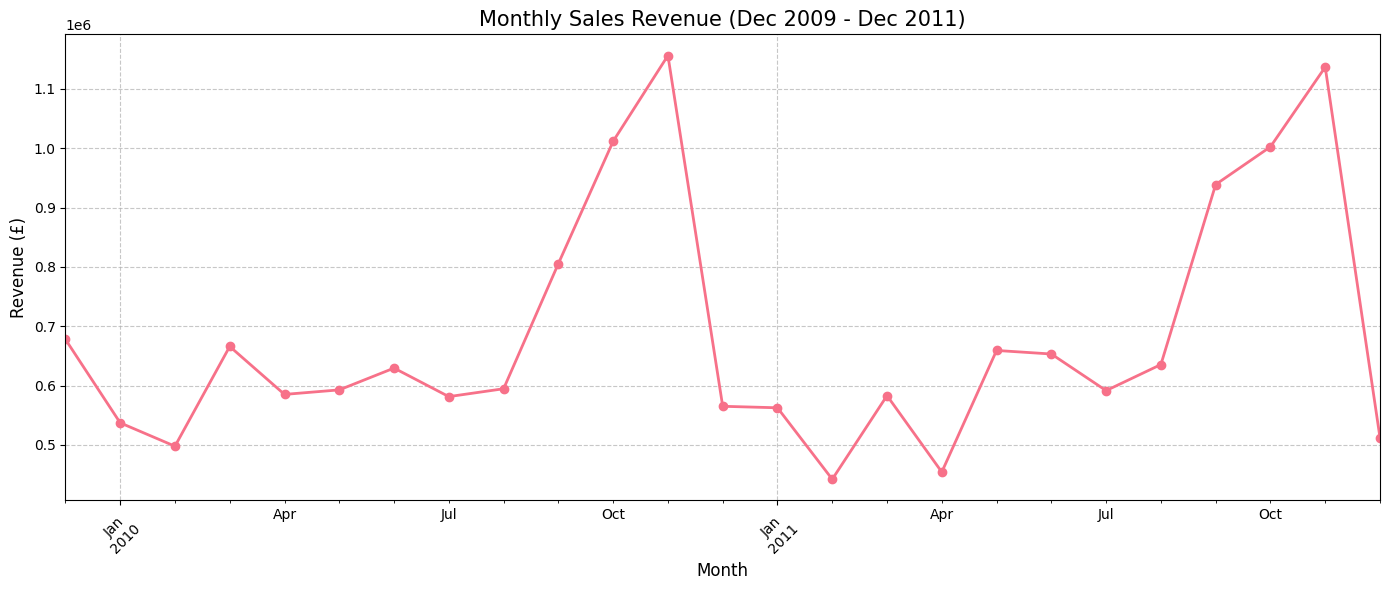

In [183]:
# Monthly Sales Revenue Analysis
monthly_sales = df_clean.set_index('InvoiceDate').resample('M')['TotalPrice'].sum()

plt.figure(figsize=(14, 6))
monthly_sales.plot(kind='line', marker='o', linewidth=2)
plt.title('Monthly Sales Revenue (Dec 2009 - Dec 2011)', fontsize=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Revenue (£)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* **Investigation of February and April Dips**: The dips in sales observed in February and April are compared across years. A bar plot is used to highlight these seasonal fluctuations.

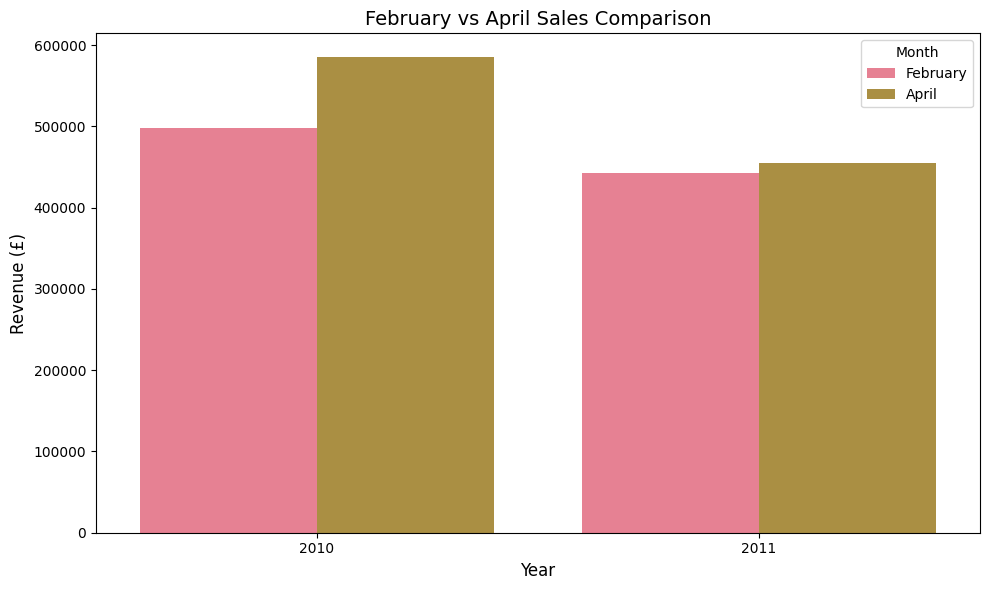

In [184]:
# Investigate February and April dips
feb_apr_comparison = monthly_sales[monthly_sales.index.month.isin([2,4])]
feb_apr_comparison = feb_apr_comparison.reset_index()
feb_apr_comparison['Year'] = feb_apr_comparison['InvoiceDate'].dt.year
feb_apr_comparison['Month'] = feb_apr_comparison['InvoiceDate'].dt.month_name()

plt.figure(figsize=(10, 6))
sns.barplot(x='Year', y='TotalPrice', hue='Month', data=feb_apr_comparison)
plt.title('February vs April Sales Comparison', fontsize=14)
plt.ylabel('Revenue (£)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.tight_layout()
plt.show()

### 2.2 Sales Patterns by Day and Hour
---

Understanding when customers are most likely to make purchases is crucial for operational decisions like inventory management, promotions, and customer support.

* **Daily Sales Patterns**: The `daily_sales` bar plot illustrates how sales are distributed across the days of the week. This insight can inform when to schedule marketing campaigns or promotions.

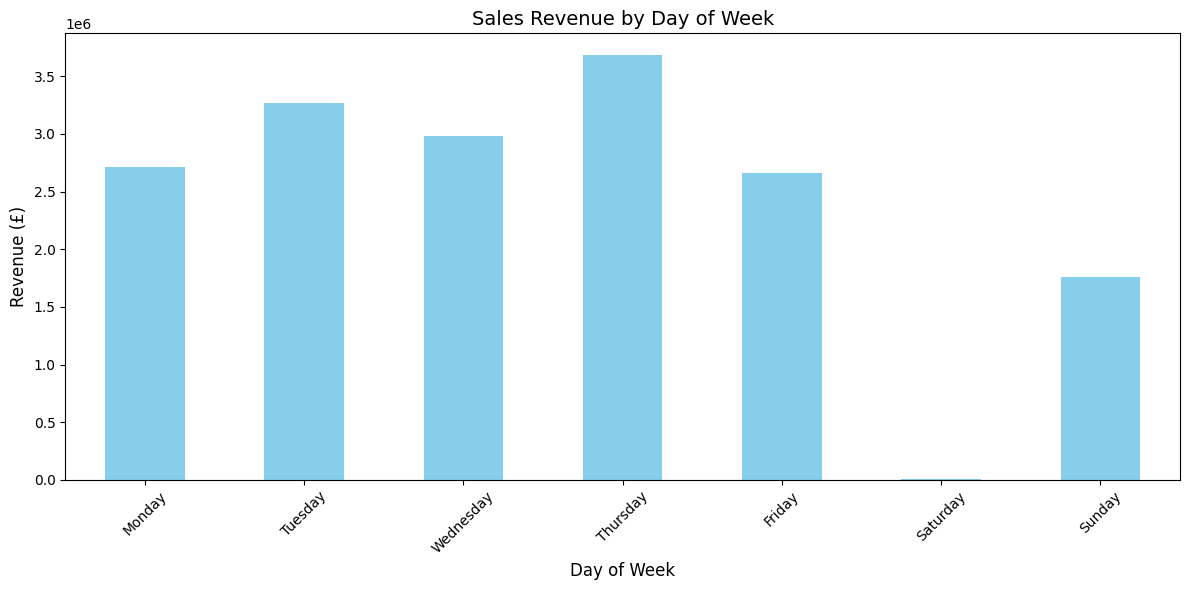

In [185]:
# Daily pattern
df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.day_name()

daily_sales = df_clean.groupby('DayOfWeek')['TotalPrice'].sum().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

plt.figure(figsize=(12, 6))
daily_sales.plot(kind='bar', color='skyblue')
plt.title('Sales Revenue by Day of Week', fontsize=14)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Revenue (£)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* **Hourly Sales Patterns**: The `hourly_sales` bar plot reveals the sales distribution by hour of the day, helping determine peak shopping hours.

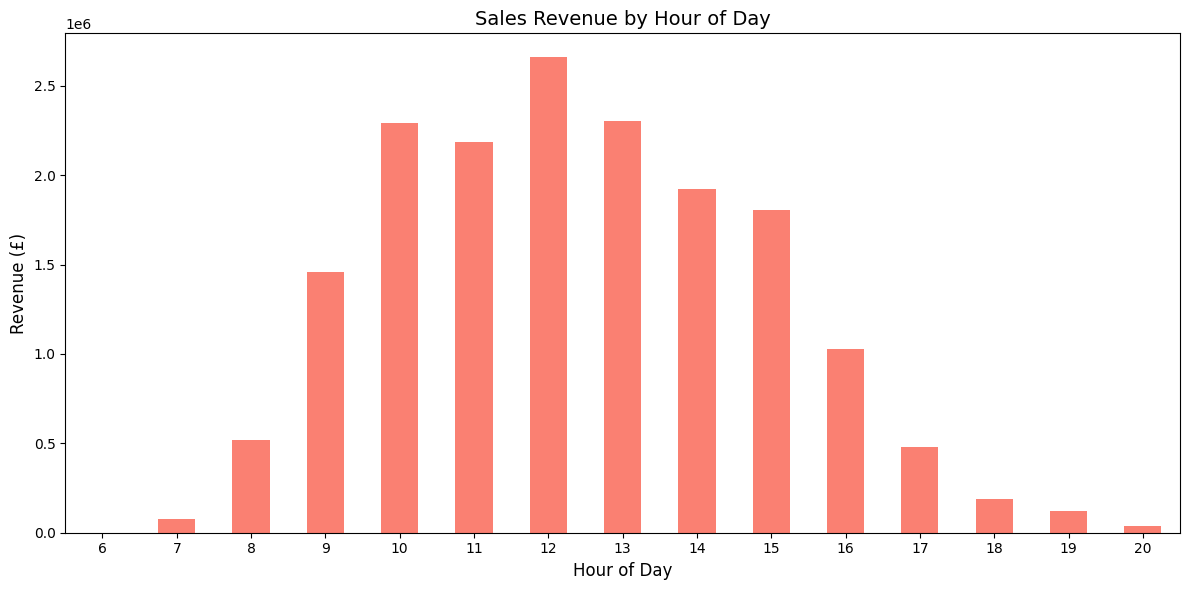

In [186]:
# Hourly pattern
df_clean['HourOfDay'] = df_clean['InvoiceDate'].dt.hour

hourly_sales = df_clean.groupby('HourOfDay')['TotalPrice'].sum()

plt.figure(figsize=(12, 6))
hourly_sales.plot(kind='bar', color='salmon')
plt.title('Sales Revenue by Hour of Day', fontsize=14)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Revenue (£)', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 2.2 Country-wise Revenue Analysis
---

This analysis investigates the contribution of various countries to the total sales revenue. By identifying the top countries, we can explore potential opportunities for international expansion.

* **Top 10 Countries by Sales Revenue**: The `country_revenue` analysis groups sales by country, and a bar plot shows the top 10 countries contributing to the total revenue.

In [187]:
# Country-wise Revenue Analysis
country_revenue = df_clean.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
top_10_countries = country_revenue.head(10)

# Display the top 10 countries by revenue
print(top_10_countries)

Country
United Kingdom    1.429161e+07
EIRE              5.880224e+05
Netherlands       5.497734e+05
Germany           3.834192e+05
France            3.094599e+05
Australia         1.678000e+05
Spain             9.799450e+04
Switzerland       9.340094e+04
Sweden            8.604514e+04
Denmark           6.742269e+04
Name: TotalPrice, dtype: float32


* **UK vs International Revenue**: We calculate the revenue contribution from the UK and compare it to international sales, using both a bar chart and a pie chart to visually represent this split.

UK Contribution: 83.71%
International Contribution: 16.29%


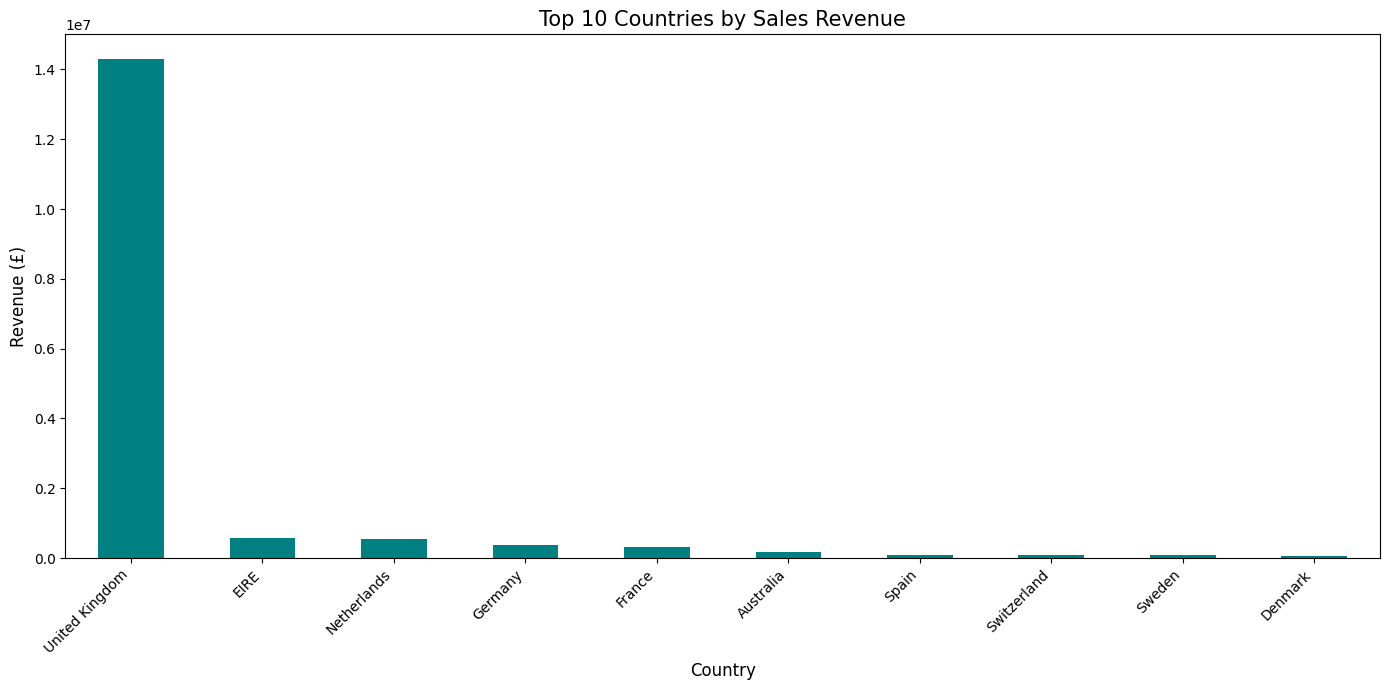

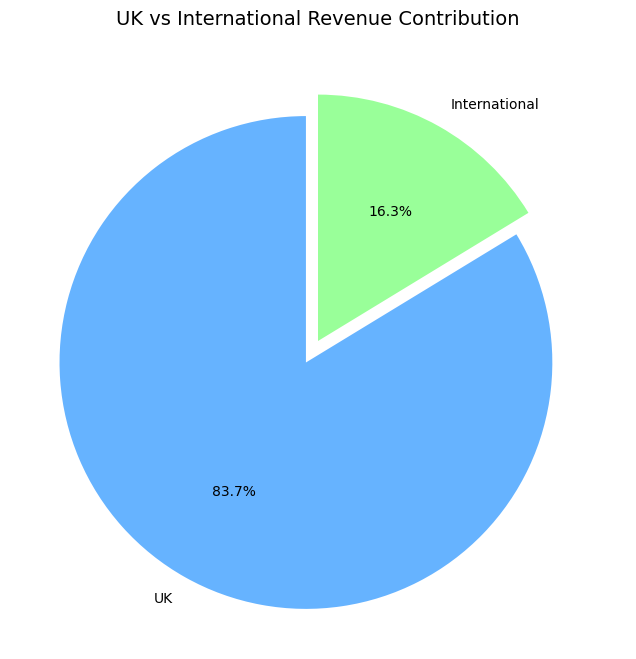

In [188]:
# UK vs International revenue
uk_revenue = country_revenue.get('United Kingdom', 0)
international_revenue = country_revenue.sum() - uk_revenue
uk_percentage = (uk_revenue / country_revenue.sum()) * 100

print(f"UK Contribution: {uk_percentage:.2f}%")
print(f"International Contribution: {100 - uk_percentage:.2f}%")

# Visualization
plt.figure(figsize=(14, 7))
top_10_countries.plot(kind='bar', color='teal')
plt.title('Top 10 Countries by Sales Revenue', fontsize=15)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Revenue (£)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Pie chart for UK vs International
plt.figure(figsize=(8, 8))
plt.pie([uk_percentage, 100 - uk_percentage],
        labels=['UK', 'International'],
        autopct='%1.1f%%',
        colors=['#66b3ff','#99ff99'],
        startangle=90,
        explode=(0.1, 0))
plt.title('UK vs International Revenue Contribution', fontsize=14)
plt.show()

### 2.3 Product Performance Analysis
---

The goal is to identify top-performing products, both in terms of quantity sold and total revenue generated. This analysis helps determine which products are "bread-and-butter" items versus "cash cows."

In [189]:
product_performance = df_clean.groupby(['StockCode', 'Description']).agg(
    TotalQuantity=('Quantity', 'sum'),
    TotalRevenue=('TotalPrice', 'sum')
).reset_index()

* **Top 10 Products by Quantity Sold**: The `top_10_quantity` bar plot identifies products that are sold most frequently, giving insight into high-volume items.

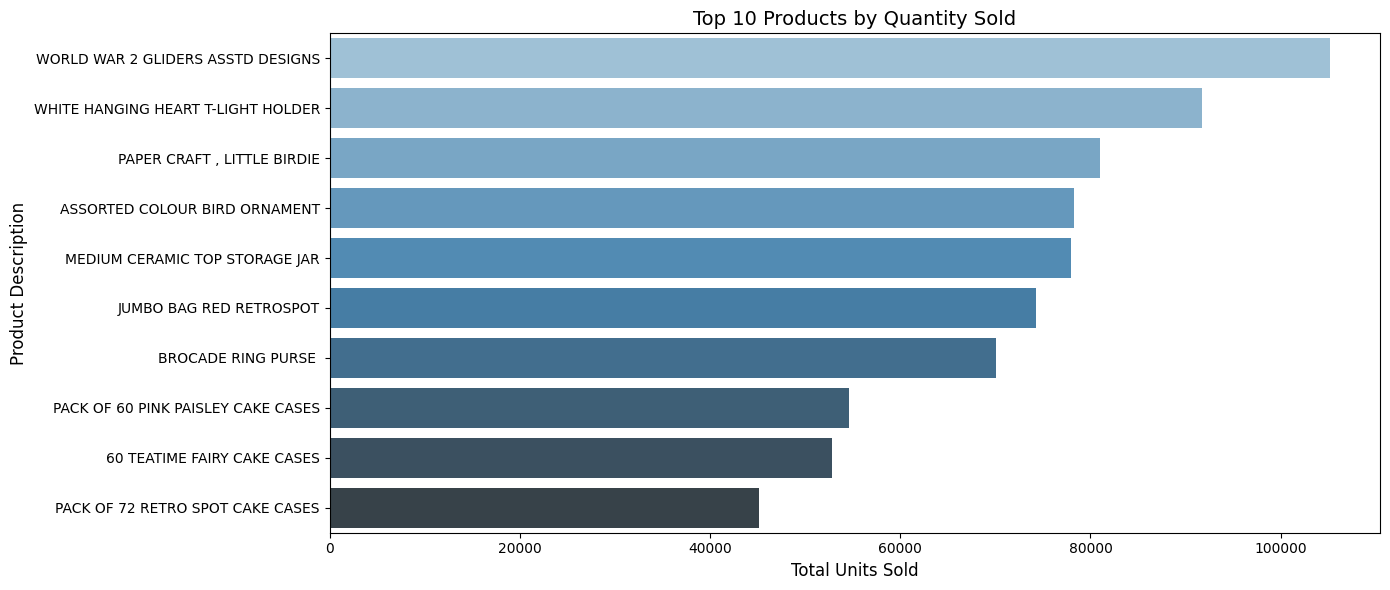

In [190]:
# Top 10 by quantity
top_10_quantity = product_performance.sort_values('TotalQuantity', ascending=False).head(10)

# Quantity plot
plt.figure(figsize=(14, 6))
sns.barplot(x='TotalQuantity', y='Description', data=top_10_quantity,
            palette='Blues_d')
plt.title('Top 10 Products by Quantity Sold', fontsize=14)
plt.xlabel('Total Units Sold', fontsize=12)
plt.ylabel('Product Description', fontsize=12)
plt.tight_layout()
plt.show()


* **Top 10 Products by Revenue**: The `top_10_revenue` bar plot identifies products that contribute the most to the company’s bottom line, helping target marketing efforts towards these "cash cow" items.

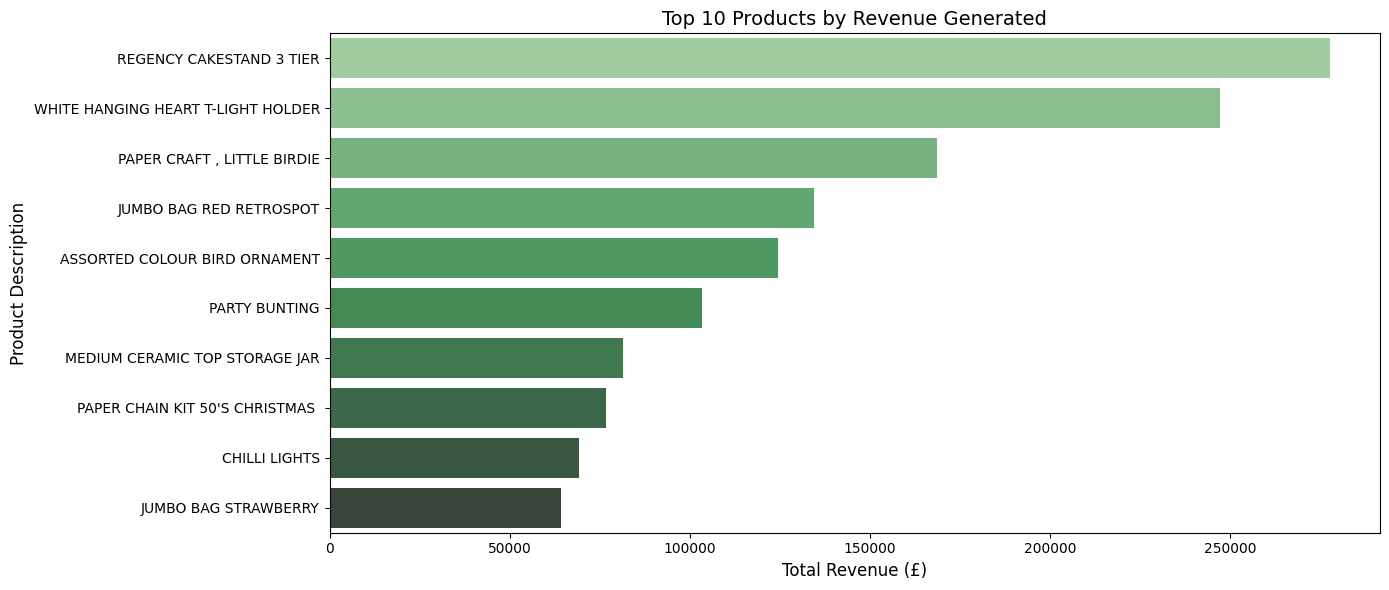

In [191]:
# Top 10 by revenue
top_10_revenue = product_performance.sort_values('TotalRevenue', ascending=False).head(10)

# Revenue plot
plt.figure(figsize=(14, 6))
sns.barplot(x='TotalRevenue', y='Description', data=top_10_revenue,
            palette='Greens_d')
plt.title('Top 10 Products by Revenue Generated', fontsize=14)
plt.xlabel('Total Revenue (£)', fontsize=12)
plt.ylabel('Product Description', fontsize=12)
plt.tight_layout()
plt.show()


* **Comparison of Quantity vs Revenue Products**: A comparison between the top 10 products by quantity sold and those by revenue reveals whether high-volume items are also high-revenue generators or if there are significant differences in the product portfolio.

In [192]:
# Comparison analysis
comparison_df = pd.merge(
    top_10_quantity[['Description']],
    top_10_revenue[['Description']],
    on='Description',
    how='outer',
    indicator=True
)

print("\nProduct Portfolio Comparison:")
print(f"Products appearing in both top lists: {comparison_df[comparison_df['_merge'] == 'both'].shape[0]}")
print(f"Quantity-only products: {comparison_df[comparison_df['_merge'] == 'left_only'].shape[0]}")
print(f"Revenue-only products: {comparison_df[comparison_df['_merge'] == 'right_only'].shape[0]}")

# Create a comparison table
comparison_table = pd.merge(
    top_10_quantity[['Description', 'TotalQuantity']],
    top_10_revenue[['Description', 'TotalRevenue']],
    on='Description',
    how='outer'
).fillna('Not in Top 10')

print("\nComparison Table:")
display(comparison_table)


Product Portfolio Comparison:
Products appearing in both top lists: 5
Quantity-only products: 5
Revenue-only products: 5

Comparison Table:


,Description,TotalQuantity,TotalRevenue
0,60 TEATIME FAIRY CAKE CASES,52828.0,Not in Top 10
1,ASSORTED COLOUR BIRD ORNAMENT,78234.0,124351.859375
2,BROCADE RING PURSE,70082.0,Not in Top 10
3,CHILLI LIGHTS,Not in Top 10,69084.296875
4,JUMBO BAG RED RETROSPOT,74224.0,134307.4375
5,JUMBO BAG STRAWBERRY,Not in Top 10,64127.769531
6,MEDIUM CERAMIC TOP STORAGE JAR,77916.0,81416.734375
7,PACK OF 60 PINK PAISLEY CAKE CASES,54592.0,Not in Top 10
8,PACK OF 72 RETRO SPOT CAKE CASES,45129.0,Not in Top 10
9,PAPER CHAIN KIT 50'S CHRISTMAS,Not in Top 10,76598.179688


# Phase 3: Advanced Analytics - RFM Customer Segmentation
---

**Team:** Code Serpents

**Team Member:** G. A. Dilsara Thiranjaya

---

## Executive Summary

This notebook implements a comprehensive RFM (Recency, Frequency, Monetary) analysis to segment customers of "Unique Gifts Ltd." based on their purchasing behavior. The analysis will help identify high-value customers, at-risk segments, and opportunities for targeted marketing strategies.

## Objectives

1. **Calculate RFM Metrics**: Compute Recency, Frequency, and Monetary values for each customer
2. **Assign RFM Scores**: Use quintile-based scoring (1-5) for each RFM dimension
3. **Customer Segmentation**: Map RFM scores to descriptive business segments

---

### Helper Functions
---

In [193]:
# ================================================================
# 1. Data Preprocessing & RFM Calculation
# ================================================================

def validate_data(data: pd.DataFrame) -> pd.DataFrame:
    """Validate and preprocess the dataset"""
    
    required_columns = ['Customer ID', 'Invoice', 'InvoiceDate', 'TotalPrice']
    missing_columns = [col for col in required_columns if col not in data.columns]
    
    if missing_columns:
        raise ValueError(f"Missing required columns: {', '.join(missing_columns)}")
    else:
        print("Data validation passed. All required columns are present.")

    # Fix data types
    if data['Customer ID'].dtype != 'int64':
        data['Customer ID'] = data['Customer ID'].astype(int)
    if not pd.api.types.is_datetime64_any_dtype(data['InvoiceDate']):
        data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
    
    return data


def calculate_rfm(data: pd.DataFrame) -> pd.DataFrame:
    """Calculate Recency, Frequency, and Monetary values for each customer"""
    
    snapshot_date = data['InvoiceDate'].max() + timedelta(days=1)
    
    rfm_data = (data.groupby('Customer ID').agg(
        Recency=('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
        Frequency=('Invoice', 'nunique'),
        Monetary=('TotalPrice', 'sum')
    ).reset_index())
    
    # Remove invalid rows
    rfm_data = rfm_data[rfm_data['Monetary'] > 0]
    return rfm_data


def get_customer_summary_stats(data: pd.DataFrame, rfm_data: pd.DataFrame) -> dict:
    """Generate summary statistics for the RFM data"""
    
    stats = {
        'total_customers': len(rfm_data),
        'recency_stats': rfm_data['Recency'].describe(),
        'frequency_stats': rfm_data['Frequency'].describe(),
        'monetary_stats': rfm_data['Monetary'].describe(),
        'snapshot_date': data['InvoiceDate'].max() + timedelta(days=1),
        'data_period': {
            'start_date': data['InvoiceDate'].min(),
            'end_date': data['InvoiceDate'].max()
        }
    }
    return stats


# ================================================================
# 2. RFM Scoring & Segmentation
# ================================================================

def create_segment_map() -> dict:
    """Create mapping from RFM scores to segment names"""
    
    segment_map = {}
    for r in range(1, 6):
        for f in range(1, 6):
            for m in range(1, 6):
                key = f"{r}{f}{m}"
                if r >= 4 and f >= 4 and m >= 4:
                    segment_map[key] = "Champions"
                elif r >= 3 and f >= 4:
                    segment_map[key] = "Loyal Customers"
                elif r >= 4 and f <= 2:
                    segment_map[key] = "Potential Loyalists"
                elif r == 5 and f <= 2:
                    segment_map[key] = "New Customers"
                elif r <= 2 and f >= 3:
                    segment_map[key] = "At-Risk Customers"
                elif r <= 2 and f <= 2:
                    segment_map[key] = "Hibernating"
    return segment_map


def assign_rfm_scores(rfm_data: pd.DataFrame) -> pd.DataFrame:
    """Assign RFM scores (1–5) for each metric"""
    
    rfm_scored = rfm_data.copy()
    
    rfm_scored['R_Score'] = pd.qcut(rfm_scored['Recency'], 5, labels=[5,4,3,2,1], duplicates='drop')
    rfm_scored['F_Score'] = pd.qcut(rfm_scored['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5], duplicates='drop')
    rfm_scored['M_Score'] = pd.qcut(rfm_scored['Monetary'], 5, labels=[1,2,3,4,5], duplicates='drop')
    
    rfm_scored = rfm_scored.astype({'R_Score': int, 'F_Score': int, 'M_Score': int})
    
    rfm_scored['RFM_Segment'] = (
        rfm_scored['R_Score'].astype(str) +
        rfm_scored['F_Score'].astype(str) +
        rfm_scored['M_Score'].astype(str)
    )
    
    return rfm_scored


def assign_segment_labels(rfm_scored: pd.DataFrame, segment_map: dict) -> pd.DataFrame:
    """Attach segment labels to RFM scored data"""
    
    rfm_final = rfm_scored.copy()
    rfm_final['Segment'] = rfm_final['RFM_Segment'].map(segment_map)
    return rfm_final


def get_segment_summary(rfm_final: pd.DataFrame) -> pd.DataFrame:
    """Generate aggregated statistics by customer segment"""
    
    segment_summary = rfm_final.groupby('Segment').agg({
        'Customer ID': 'count',
        'Recency': ['mean', 'median'],
        'Frequency': ['mean', 'median'],
        'Monetary': ['mean', 'median', 'sum']
    }).round(2)

    segment_summary.columns = [
        'Customer_Count',
        'Avg_Recency', 'Median_Recency',
        'Avg_Frequency', 'Median_Frequency',
        'Avg_Monetary', 'Median_Monetary', 'Total_Revenue'
    ]
    
    segment_summary['Customer_Percentage'] = (
        segment_summary['Customer_Count'] / segment_summary['Customer_Count'].sum() * 100
    ).round(2)
    segment_summary['Revenue_Percentage'] = (
        segment_summary['Total_Revenue'] / segment_summary['Total_Revenue'].sum() * 100
    ).round(2)
    
    return segment_summary.sort_values('Customer_Count', ascending=False)


# ================================================================
# 3. Visualizations
# ================================================================

def plot_rfm_distributions(rfm_data: pd.DataFrame, figsize: Tuple[int, int] = (15, 10)):
    """Plot histograms of RFM metrics"""
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('RFM Metrics Distribution Analysis', fontsize=16, fontweight='bold')
    
    axes[0, 0].hist(rfm_data['Recency'], bins=50, color='skyblue', alpha=0.7, edgecolor='black')
    axes[0, 0].set_title('Recency Distribution')
    axes[0, 0].axvline(rfm_data['Recency'].mean(), color='red', linestyle='--')

    axes[0, 1].hist(rfm_data['Frequency'], bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Frequency Distribution')
    axes[0, 1].axvline(rfm_data['Frequency'].mean(), color='red', linestyle='--')

    axes[1, 0].hist(np.log10(rfm_data['Monetary']), bins=50, color='gold', alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Monetary Distribution (Log10 Scale)')
    axes[1, 0].axvline(np.log10(rfm_data['Monetary'].mean()), color='red', linestyle='--')
    
    plt.tight_layout()
    return fig


def plot_segment_analysis(segment_summary: pd.DataFrame, figsize: Tuple[int, int] = (15, 10)):
    """Plot bar/pie charts for customer segments"""
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('Customer Segment Analysis', fontsize=16, fontweight='bold')
    
    segment_summary.plot(kind='bar', y='Customer_Count', ax=axes[0, 0], color='steelblue', alpha=0.8)
    axes[0, 0].set_title('Number of Customers by Segment')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].legend().remove()
    
    axes[0, 1].pie(segment_summary['Revenue_Percentage'], labels=segment_summary.index, autopct='%1.1f%%')
    axes[0, 1].set_title('Revenue Distribution by Segment')
    
    segment_summary.plot(kind='bar', y='Avg_Monetary', ax=axes[1, 0], color='darkorange', alpha=0.8)
    axes[1, 0].set_title('Average Monetary Value by Segment')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].legend().remove()
    
    plt.tight_layout()
    return fig


### 3.1 Data Preprocessing & RFM Calculation
---

Before performing the RFM analysis, the dataset is validated and preprocessed to ensure it contains all the required columns and the correct data types.

- **Data Validation**: The `validate_data()` function checks that the dataset contains the necessary columns (`Customer ID`, `Invoice`, `InvoiceDate`, and `TotalPrice`), and converts data types as needed (e.g., converting `InvoiceDate` to `datetime`).

In [194]:
df_clean = validate_data(df_clean)

Data validation passed. All required columns are present.


* **RFM Calculation**: The `calculate_rfm()` function calculates three metrics for each customer:

  * **Recency**: The number of days since the customer's last purchase.
  * **Frequency**: The number of unique transactions made by the customer.
  * **Monetary**: The total spending of the customer.

In [195]:
rfm_data = calculate_rfm(df_clean)

# Display sample of RFM data
print("\nSample RFM Data:")
display(rfm_data.head(10))


Sample RFM Data:


,Customer ID,Recency,Frequency,Monetary
0,12346,326,12,77556.460938
1,12347,2,8,4921.529785
2,12348,75,5,1658.400024
3,12349,19,3,3678.689941
4,12350,310,1,294.399994
5,12351,375,1,300.929993
6,12352,36,9,1729.540039
7,12353,204,2,406.760010
8,12354,232,1,1079.400024
9,12355,214,2,947.609985


* **Customer Summary Stats**: The `get_customer_summary_stats()` function generates summary statistics, including the total number of customers, and descriptive statistics for the RFM metrics.

In [196]:
summary_stats = get_customer_summary_stats(df_clean, rfm_data)

# Display comprehensive summary statistics
print("RFM ANALYSIS SUMMARY STATISTICS")
print("=" * 50)

print(f"\nAnalysis Overview:")
print(f"Total Customers Analyzed: {summary_stats['total_customers']:,}")
print(f"Analysis Period: {summary_stats['data_period']['start_date'].strftime('%Y-%m-%d')} to {summary_stats['data_period']['end_date'].strftime('%Y-%m-%d')}")
print(f"Snapshot Date: {summary_stats['snapshot_date'].strftime('%Y-%m-%d')}")

print(f"\nRecency Statistics (Days since last purchase):")
print(summary_stats['recency_stats'])

print(f"\nFrequency Statistics (Number of transactions):")
print(summary_stats['frequency_stats'])

print(f"\nMonetary Statistics (Total spent in £):")
print(summary_stats['monetary_stats'])

RFM ANALYSIS SUMMARY STATISTICS

Analysis Overview:
Total Customers Analyzed: 5,861
Analysis Period: 2009-12-01 to 2011-12-09
Snapshot Date: 2011-12-10

Recency Statistics (Days since last purchase):
count    5861.000000
mean      200.937895
std       209.201911
min         1.000000
25%        26.000000
50%        96.000000
75%       379.000000
max       739.000000
Name: Recency, dtype: float64

Frequency Statistics (Number of transactions):
count    5861.000000
mean        6.252175
std        12.778230
min         1.000000
25%         1.000000
50%         3.000000
75%         7.000000
max       376.000000
Name: Frequency, dtype: float64

Monetary Statistics (Total spent in £):
count      5861.000000
mean       2913.065430
std       14300.687500
min           2.950000
25%         338.130005
50%         854.989990
75%        2237.119873
max      580987.062500
Name: Monetary, dtype: float64


### 3.2 RFM Scoring & Segmentation
---

After calculating the RFM metrics, each customer is assigned scores (1–5) based on their recency, frequency, and monetary values. This allows us to segment customers into different categories:

* **RFM Scores**: The `assign_rfm_scores()` function assigns scores to customers using `qcut()` to divide the data into quintiles, creating the R, F, and M scores.

In [197]:
rfm_scored = assign_rfm_scores(rfm_data)

# Display sample of RFM scored data
print("\nSample of RFM Scored Data:")
display(rfm_scored.head(10))

# Display RFM score distribution
print("\nRFM Score Distribution:")
score_dist = pd.DataFrame({
    'R_Score': rfm_scored['R_Score'].value_counts().sort_index(),
    'F_Score': rfm_scored['F_Score'].value_counts().sort_index(),
    'M_Score': rfm_scored['M_Score'].value_counts().sort_index()
})
display(score_dist)


Sample of RFM Scored Data:


,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment
0,12346,326,12,77556.460938,2,5,5,255
1,12347,2,8,4921.529785,5,4,5,545
2,12348,75,5,1658.400024,3,4,4,344
3,12349,19,3,3678.689941,5,3,5,535
4,12350,310,1,294.399994,2,1,2,212
5,12351,375,1,300.929993,2,1,2,212
6,12352,36,9,1729.540039,4,5,4,454
7,12353,204,2,406.760010,2,2,2,222
8,12354,232,1,1079.400024,2,1,3,213
9,12355,214,2,947.609985,2,2,3,223



RFM Score Distribution:


,R_Score,F_Score,M_Score
1,1172,1173,1173
2,1169,1172,1172
3,1159,1172,1172
4,1174,1172,1172
5,1187,1172,1172


* **Segment Mapping**: The `create_segment_map()` function assigns segment labels based on the RFM scores, such as "Champions," "Loyal Customers," and "At-Risk Customers."

In [198]:
segment_map = create_segment_map()
rfm_final = assign_segment_labels(rfm_scored, segment_map)

# Display sample of final segmented data
print("\nSample of Final Segmented Data:")
display(rfm_final.head(10))


Sample of Final Segmented Data:


,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,Segment
0,12346,326,12,77556.460938,2,5,5,255,At-Risk Customers
1,12347,2,8,4921.529785,5,4,5,545,Champions
2,12348,75,5,1658.400024,3,4,4,344,Loyal Customers
3,12349,19,3,3678.689941,5,3,5,535,NaN
4,12350,310,1,294.399994,2,1,2,212,Hibernating
5,12351,375,1,300.929993,2,1,2,212,Hibernating
6,12352,36,9,1729.540039,4,5,4,454,Champions
7,12353,204,2,406.760010,2,2,2,222,Hibernating
8,12354,232,1,1079.400024,2,1,3,213,Hibernating
9,12355,214,2,947.609985,2,2,3,223,Hibernating


* **Segment Summary**: The `get_segment_summary()` function generates a detailed summary of customer segments, including the count of customers per segment, and key statistics like average recency, frequency, and monetary values.

In [199]:
segment_summary = get_segment_summary(rfm_final)

# Displaying the final segment summary
display(segment_summary)

# Analyze segment characteristics in detail
print("DETAILED SEGMENT CHARACTERISTICS")
print("=" * 50)

for segment in segment_summary.index:
    segment_data = segment_summary.loc[segment]
    
    print(f"\n{segment.upper()}:")
    print(f"   Customers: {segment_data['Customer_Count']:,} ({segment_data['Customer_Percentage']:.1f}% of total)")
    print(f"   Revenue: £{segment_data['Total_Revenue']:,.2f} ({segment_data['Revenue_Percentage']:.1f}% of total)")
    print(f"   Avg Recency: {segment_data['Avg_Recency']:.0f} days")
    print(f"   Avg Frequency: {segment_data['Avg_Frequency']:.1f} transactions")
    print(f"   Avg Monetary: £{segment_data['Avg_Monetary']:,.2f}")
    
    # Add business interpretation
    if 'Champions' in segment:
        print(f"   Interpretation: These are your best customers - recent, frequent, high-value purchases")
    elif 'Loyal' in segment:
        print(f"   Interpretation: Regular customers who respond well to promotions")
    elif 'At-Risk' in segment:
        print(f"   Interpretation: Previously valuable customers who may be churning - need retention efforts")
    elif 'New' in segment:
        print(f"   Interpretation: Recent customers with growth potential - focus on onboarding")
    elif 'Hibernating' in segment:
        print(f"   Interpretation: Inactive customers - evaluate cost-effectiveness of win-back campaigns")
    elif 'Cannot Lose' in segment:
        print(f"   Interpretation: High-value customers at risk - prioritize immediate retention efforts")
    else:
        print(f"   Interpretation: Unique segment requiring tailored marketing approach")

,Customer_Count,Avg_Recency,Median_Recency,Avg_Frequency,Median_Frequency,Avg_Monetary,Median_Monetary,Total_Revenue,Customer_Percentage,Revenue_Percentage
Segment,,,,,,,,,,
Hibernating,1514,458.27,433.0,1.25,1.0,408.700012,273.279999,6.187754e+05,31.67,3.850000
Champions,1292,19.98,16.0,17.00,11.0,9024.469727,3900.969971,1.165962e+07,27.02,72.489998
At-Risk Customers,827,369.20,374.0,4.97,4.0,1921.520020,1015.239990,1.589096e+06,17.30,9.880000
Loyal Customers,697,84.13,78.0,7.63,6.0,2582.840088,1608.930054,1.800238e+06,14.58,11.190000
Potential Loyalists,451,28.13,26.0,1.46,1.0,923.309998,365.450012,4.164148e+05,9.43,2.590000


DETAILED SEGMENT CHARACTERISTICS

HIBERNATING:
   Customers: 1,514.0 (31.7% of total)
   Revenue: £618,775.44 (3.8% of total)
   Avg Recency: 458 days
   Avg Frequency: 1.2 transactions
   Avg Monetary: £408.70
   Interpretation: Inactive customers - evaluate cost-effectiveness of win-back campaigns

CHAMPIONS:
   Customers: 1,292.0 (27.0% of total)
   Revenue: £11,659,619.00 (72.5% of total)
   Avg Recency: 20 days
   Avg Frequency: 17.0 transactions
   Avg Monetary: £9,024.47
   Interpretation: These are your best customers - recent, frequent, high-value purchases

AT-RISK CUSTOMERS:
   Customers: 827.0 (17.3% of total)
   Revenue: £1,589,096.38 (9.9% of total)
   Avg Recency: 369 days
   Avg Frequency: 5.0 transactions
   Avg Monetary: £1,921.52
   Interpretation: Previously valuable customers who may be churning - need retention efforts

LOYAL CUSTOMERS:
   Customers: 697.0 (14.6% of total)
   Revenue: £1,800,237.62 (11.2% of total)
   Avg Recency: 84 days
   Avg Frequency: 7.6 tra

### 3.3  Visualizations
---

Visualizing the RFM metrics and customer segments helps in understanding the distribution of customers and their behavior.

* **RFM Distributions**: The `plot_rfm_distributions()` function generates histograms for the **Recency**, **Frequency**, and **Monetary** distributions, allowing us to see how customers are distributed across these metrics.

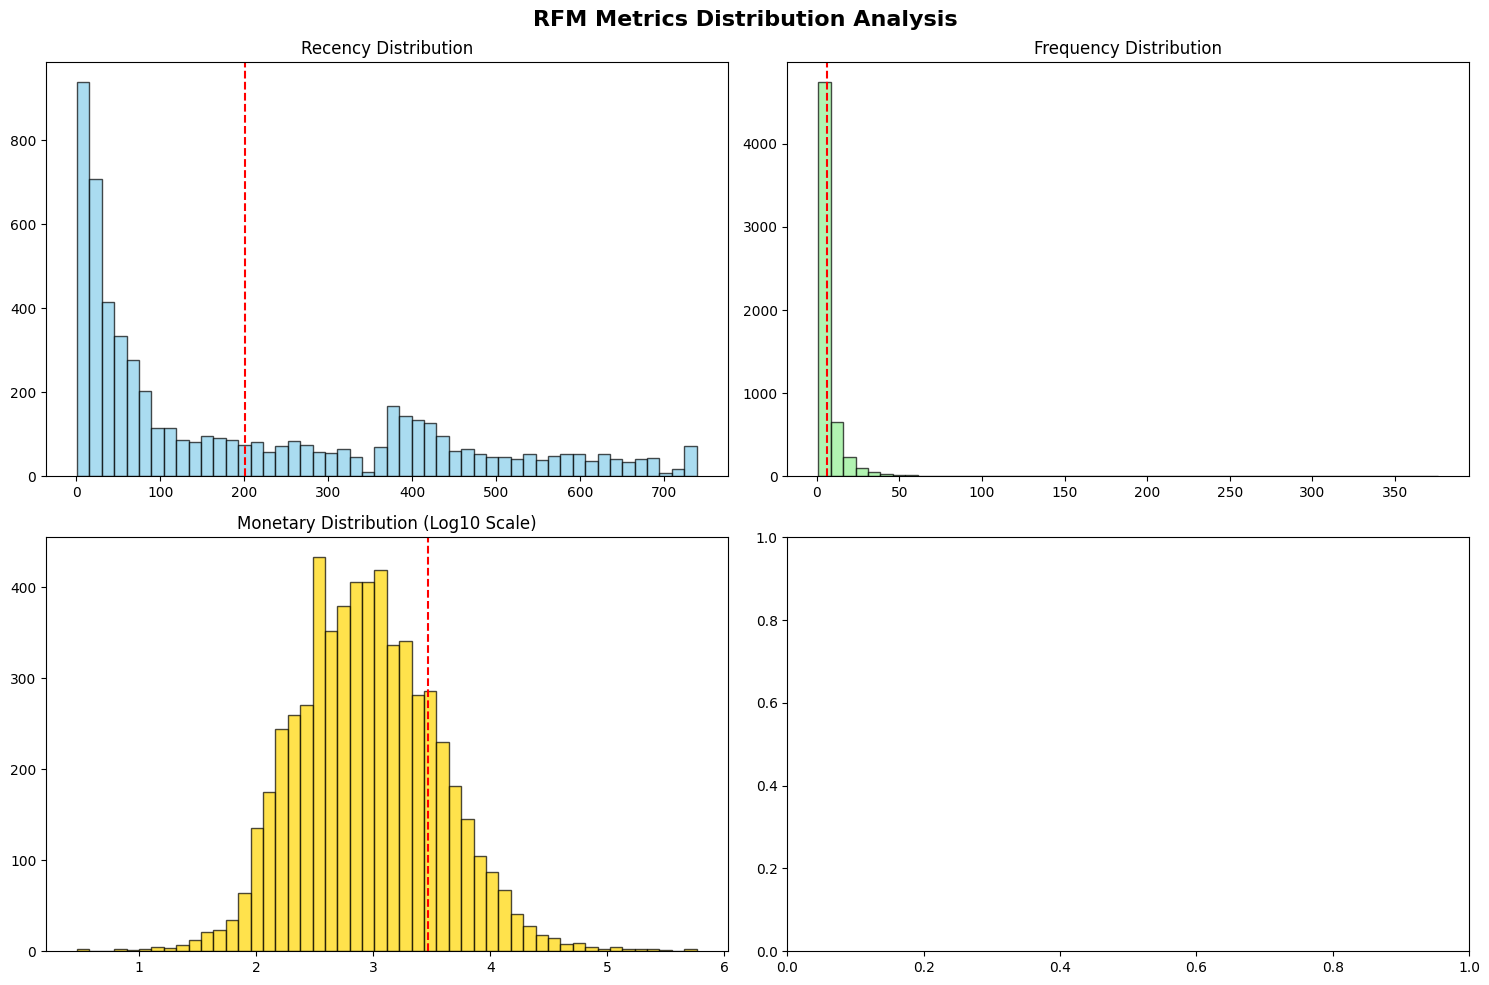

In [200]:
figures = {}

figures['distributions'] = plot_rfm_distributions(rfm_final)

* **Segment Analysis**: The `plot_segment_analysis()` function visualizes customer segments with bar charts for customer count and average monetary value, and a pie chart for revenue distribution by segment.

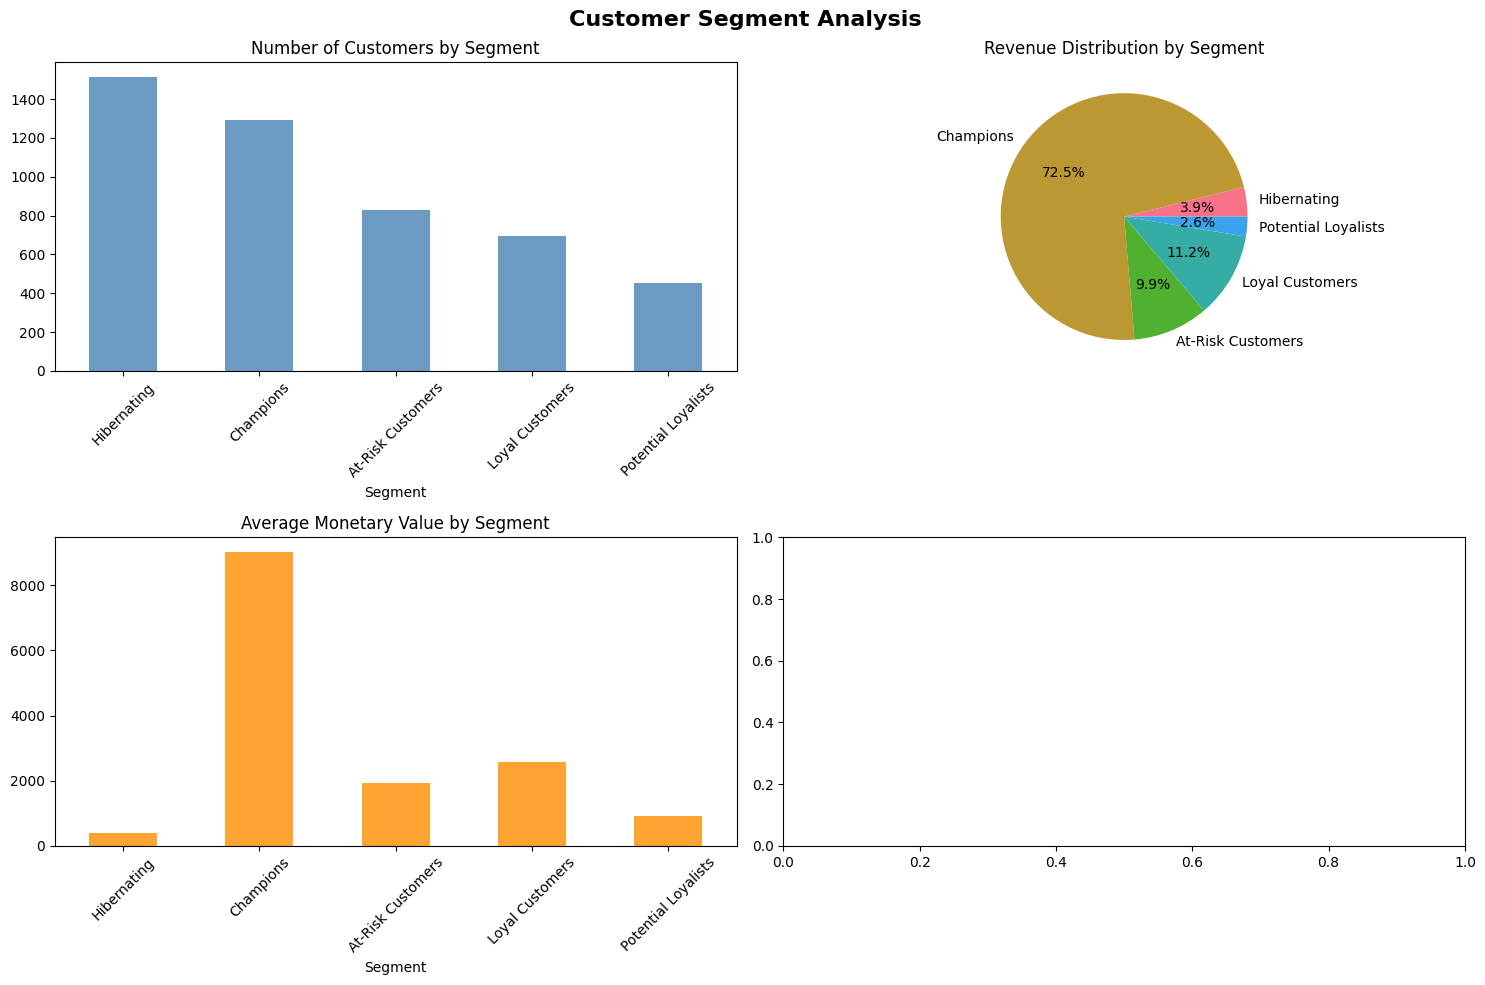

In [201]:
figures['segments'] = plot_segment_analysis(segment_summary)

### 3.4 Customer Segment Insights
---

Once the segmentation is complete, we generate a detailed analysis of each segment, including:

* **Largest Segment**: Identifying the segment with the highest number of customers.
* **Highest Revenue Segment**: Finding the segment contributing the most to revenue.
* **Highest Average Spend**: The segment with the highest average monetary value per customer.
* **Customer Distribution Across Segments:**: The spread of customers among different segments.

In [202]:
# Sample insights for 'Champions' and other segments
print(f"• Largest Segment: {segment_summary.index[0]} ({segment_summary.iloc[0]['Customer_Count']:,} customers, {segment_summary.iloc[0]['Customer_Percentage']:.1f}%)")
print(f"• Highest Revenue Segment: {segment_summary.sort_values('Total_Revenue', ascending=False).index[0]}")
print(f"• Highest Average Spend: {segment_summary.sort_values('Avg_Monetary', ascending=False).index[0]} (£{segment_summary.sort_values('Avg_Monetary', ascending=False).iloc[0]['Avg_Monetary']:,.2f})")

# Segment distribution
print(f"\nCustomer Distribution Across Segments:")
segment_counts = rfm_final['Segment'].value_counts()
for segment, count in segment_counts.items():
    percentage = (count / len(rfm_final)) * 100
    print(f"• {segment}: {count:,} customers ({percentage:.1f}%)")

• Largest Segment: Hibernating (1,514.0 customers, 31.7%)
• Highest Revenue Segment: Champions
• Highest Average Spend: Champions (£9,024.47)

Customer Distribution Across Segments:
• Hibernating: 1,514 customers (25.8%)
• Champions: 1,292 customers (22.0%)
• At-Risk Customers: 827 customers (14.1%)
• Loyal Customers: 697 customers (11.9%)
• Potential Loyalists: 451 customers (7.7%)


# Phase 4: Strategic Recommendations
---

**Team:** Code Serpents

**Team Member:** K. D. Vihanga Heshan Bandara

---

## Executive Summary

This notebook translates analytical findings into actionable business strategies. It investigates the wholesaler hypothesis and provides data-driven recommendations for customer segmentation, marketing strategies, and business growth opportunities.

## Objectives

1. **Wholesaler Analysis**: Investigate purchasing behavior differences between wholesalers and retail customers
2. **Segment Strategy**: Develop targeted strategies for each RFM customer segment
3. **Strategic Recommendations**: Provide actionable insights for marketing, inventory, and customer relationship management

---

### Helper Functions
---

In [203]:
# ================================================================
# 1. Data Loading & Validation
# ================================================================
def validate_rfm_data(df):
    """Validate the RFM customer segments data"""
    
    try:
        if 'Monetary' not in df.columns:
            raise ValueError("CSV must contain 'Monetary' column")
        print(f"Data loaded successfully: {df.shape}")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# ================================================================
# 2. Monetary Distribution Analysis
# ================================================================
def analyze_monetary_distribution(df):
    """Analyze the distribution of monetary values to investigate wholesaler hypothesis."""
    
    monetary_values = df['Monetary']
    
    # Calculate key statistics
    stats = {
        'total_customers': len(monetary_values),
        'mean_spending': monetary_values.mean(),
        'median_spending': monetary_values.median(),
        'std_spending': monetary_values.std(),
        'min_spending': monetary_values.min(),
        'max_spending': monetary_values.max(),
        'skewness': monetary_values.skew(),
        'percentiles': {
            '25th': monetary_values.quantile(0.25),
            '75th': monetary_values.quantile(0.75),
            '90th': monetary_values.quantile(0.90),
            '95th': monetary_values.quantile(0.95),
            '99th': monetary_values.quantile(0.99)
        }
    }
    
    # Wholesaler analysis (top 5% spenders)
    wholesale_threshold = stats['percentiles']['95th']
    potential_wholesalers = monetary_values[monetary_values >= wholesale_threshold]
    
    stats['wholesale_analysis'] = {
        'threshold_95th': wholesale_threshold,
        'potential_wholesaler_count': len(potential_wholesalers),
        'potential_wholesaler_percentage': (len(potential_wholesalers) / len(monetary_values)) * 100,
        'wholesaler_revenue_share': (potential_wholesalers.sum() / monetary_values.sum()) * 100
    }
    
    return stats

# ================================================================
# 3. Visualization Functions
# ================================================================
def create_monetary_histogram(df, stats, bins=50, figsize=(15, 10)):
    """Create comprehensive histogram to visualize monetary distribution"""
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('Customer Monetary Value Distribution Analysis\n(Investigating Wholesaler Hypothesis)', 
                 fontsize=16, fontweight='bold')
    
    monetary_values = df['Monetary']
    
    # 1. Standard histogram with key statistics
    axes[0, 0].hist(monetary_values, bins=bins, color='skyblue', alpha=0.7, edgecolor='black')
    axes[0, 0].set_title('Distribution of Customer Spending')
    axes[0, 0].set_xlabel('Total Spending (£)')
    axes[0, 0].set_ylabel('Number of Customers')
    axes[0, 0].axvline(stats['mean_spending'], color='red', linestyle='--', 
                      label=f'Mean: £{stats["mean_spending"]:.0f}')
    axes[0, 0].axvline(stats['median_spending'], color='orange', linestyle='--', 
                      label=f'Median: £{stats["median_spending"]:.0f}')
    axes[0, 0].axvline(stats['percentiles']['95th'], color='purple', linestyle='--', 
                      label=f'95th percentile: £{stats["percentiles"]["95th"]:.0f}')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Log scale histogram
    log_monetary = np.log10(monetary_values + 1)
    axes[0, 1].hist(log_monetary, bins=bins, color='lightgreen', alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Distribution (Log10 Scale)')
    axes[0, 1].set_xlabel('Log10(Total Spending + 1)')
    axes[0, 1].set_ylabel('Number of Customers')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Zoomed histogram (exclude top 1%)
    percentile_99 = stats['percentiles']['99th']
    main_distribution = monetary_values[monetary_values <= percentile_99]
    axes[1, 0].hist(main_distribution, bins=bins, color='gold', alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Distribution (Excluding Top 1% Spenders)')
    axes[1, 0].set_xlabel('Total Spending (£)')
    axes[1, 0].set_ylabel('Number of Customers')
    axes[1, 0].axvline(main_distribution.mean(), color='red', linestyle='--', 
                      label=f'Mean (excl. top 1%): £{main_distribution.mean():.0f}')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Box plot
    box = axes[1, 1].boxplot(monetary_values, vert=True, patch_artist=True,
                            boxprops=dict(facecolor='lightcoral', alpha=0.7))
    axes[1, 1].set_title('Box Plot of Customer Spending\n(Shows Outliers)')
    axes[1, 1].set_ylabel('Total Spending (£)')
    axes[1, 1].set_xlabel('All Customers')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    return fig

# ================================================================
# 4. Customer Segmentation
# ================================================================
def identify_customer_segments(df):
    """Identify potential retail vs wholesale customers based on spending patterns."""
    
    p90 = df['Monetary'].quantile(0.90)
    p95 = df['Monetary'].quantile(0.95)
    
    def categorize_customer(monetary_value):
        if monetary_value >= p95:
            return 'High-Value Wholesale'
        elif monetary_value >= p90:
            return 'Potential Wholesale'
        else:
            return 'Retail Customer'
    
    df['Customer_Type'] = df['Monetary'].apply(categorize_customer)
    return df

# ================================================================
# 5. Insights Generation
# ================================================================
def generate_insights_summary(stats):
    """Generate text summary of wholesaler hypothesis findings."""
    
    summary = f"""
            WHOLESALER HYPOTHESIS INVESTIGATION SUMMARY
            ===========================================

            Dataset Overview:
            - Total Customers Analyzed: {stats['total_customers']:,}
            - Average Customer Spending: £{stats['mean_spending']:.2f}
            - Median Customer Spending: £{stats['median_spending']:.2f}
            - Distribution Skewness: {stats['skewness']:.2f} (Positive = Right-skewed)

            Key Findings:
            1. Distribution Shape: {'Highly right-skewed' if stats['skewness'] > 2 else 'Moderately skewed' if stats['skewness'] > 1 else 'Relatively normal'}
            2. Mean vs Median Gap: £{stats['mean_spending'] - stats['median_spending']:.2f}
            (Large gap indicates presence of high-spending outliers)

            Potential Wholesaler Analysis:
            - 95th Percentile Threshold: £{stats['wholesale_analysis']['threshold_95th']:.2f}
            - Potential Wholesalers (Top 5%): {stats['wholesale_analysis']['potential_wholesaler_count']} customers
            - Revenue Share of Top 5%: {stats['wholesale_analysis']['wholesaler_revenue_share']:.1f}%

            Interpretation:
            {'Strong evidence of two distinct customer groups - likely retail vs wholesale customers.' if stats['wholesale_analysis']['wholesaler_revenue_share'] > 30 else 'Some evidence of high-value customers, but distribution may not clearly show wholesale segment.'}
            {'The high skewness and significant revenue concentration suggest wholesale presence.' if stats['skewness'] > 2 else 'Distribution suggests more uniform customer base.'}
    """
    
    print(summary)
    return summary

### 4.1 Data Loading & Validation
---

We begin by validating the data to ensure that the required column, **Monetary**, is present. If the data is valid, we proceed with the analysis.

In [204]:
df_rfm = validate_rfm_data(rfm_final)

Data loaded successfully: (5861, 9)


### Dataset Overview:

* **Data Loaded Successfully**: The dataset is loaded and validated with the required columns.
* **Monetary Statistics**: We check the basic statistics for the **Monetary** column to understand the distribution of spending.

In [205]:
print(f"\nMonetary column statistics:")
print(df_rfm['Monetary'].describe())


Monetary column statistics:
count      5861.000000
mean       2913.065430
std       14300.687500
min           2.950000
25%         338.130005
50%         854.989990
75%        2237.119873
max      580987.062500
Name: Monetary, dtype: float64


### 4.2 Monetary Distribution Analysis
---

We analyze the **Monetary** distribution to investigate the potential presence of wholesalers (high-spending customers). This is done by calculating key statistics like mean, median, skewness, and percentiles. We also identify the **top 5% spenders**, who are potential wholesalers.

In [206]:
stats = analyze_monetary_distribution(df_rfm)

### Key Statistics:

In [207]:
print(f"Mean spending: £{stats['mean_spending']:.2f}")
print(f"Median spending: £{stats['median_spending']:.2f}")
print(f"Standard deviation: £{stats['std_spending']:.2f}")
print(f"Skewness: {stats['skewness']:.2f}")
print(f"95th percentile threshold: £{stats['percentiles']['95th']:.2f}")
print(f"Potential wholesalers: {stats['wholesale_analysis']['potential_wholesaler_count']} ({stats['wholesale_analysis']['potential_wholesaler_percentage']:.1f}%)")
print(f"Wholesaler revenue share: {stats['wholesale_analysis']['wholesaler_revenue_share']:.1f}%")

Mean spending: £2913.07
Median spending: £854.99
Standard deviation: £14300.69
Skewness: 25.34
95th percentile threshold: £9266.00
Potential wholesalers: 294 (5.0%)
Wholesaler revenue share: 52.0%


### 4.3 Visualization of Monetary Distribution
---

The distribution of customer spending is visualized using histograms and box plots to better understand the shape of the data, particularly focusing on high-spending customers.

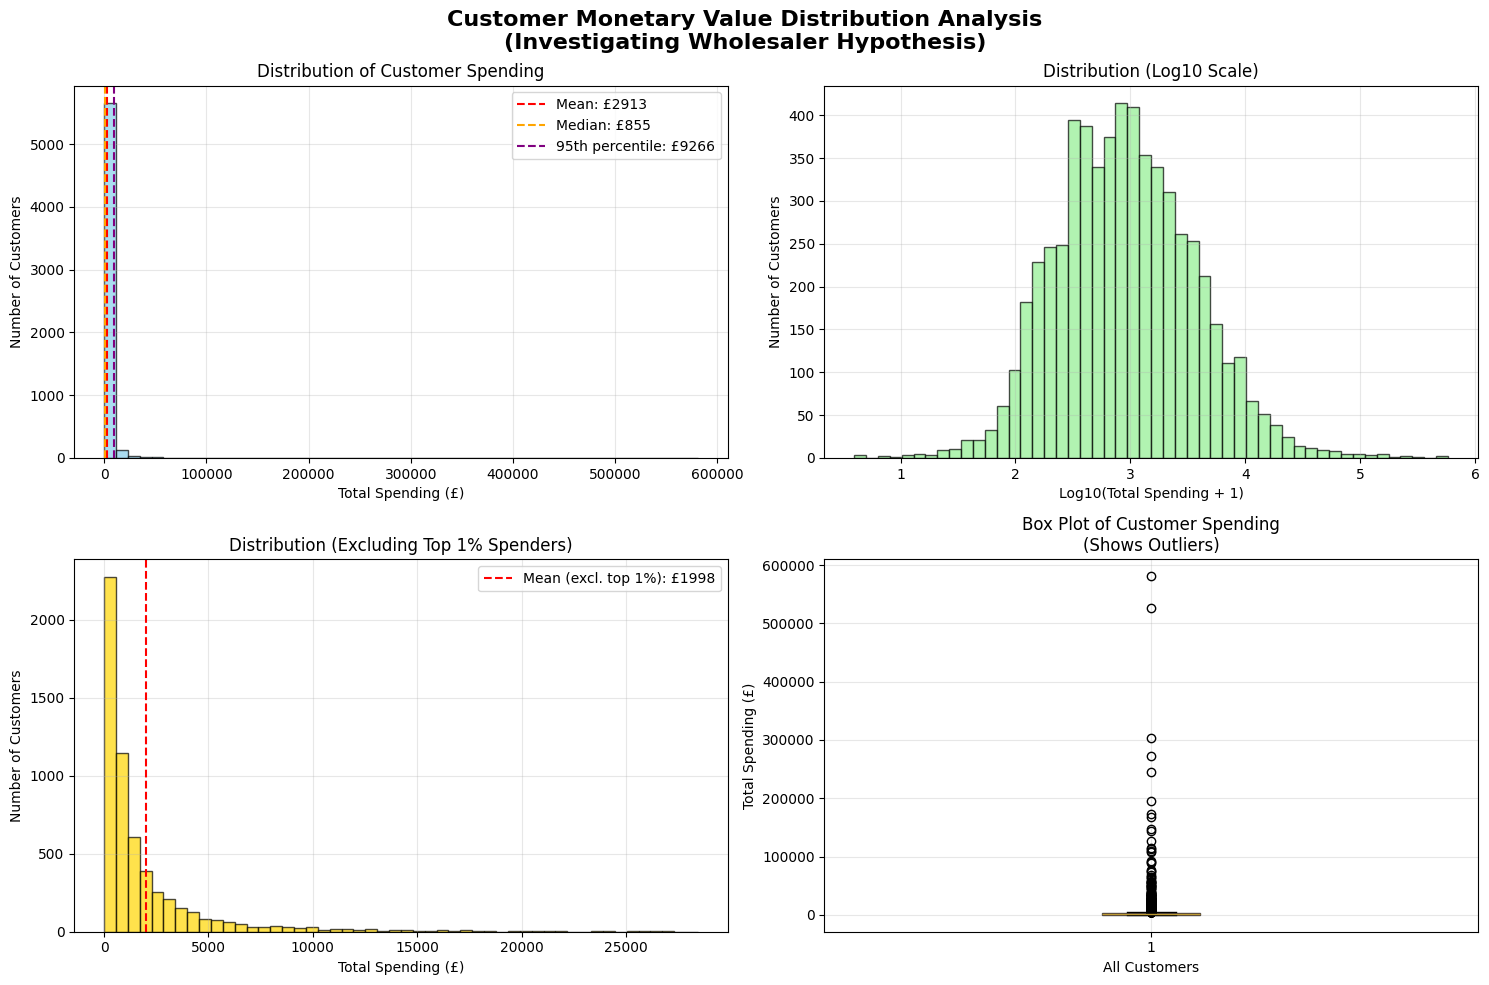

In [208]:
fig = create_monetary_histogram(df_rfm, stats)

### Key Insights:

* **Standard Distribution**: The histogram visualizes the total spending distribution, highlighting the mean, median, and 95th percentile.
* **Logarithmic Scale**: We analyze the distribution on a log scale to handle the wide range of spending values.
* **Excluding Top 1%**: We zoom in on the main distribution by excluding the top 1% of spenders.
* **Box Plot**: Displays the spread and outliers in customer spending.

### 4.4 Customer Segmentation
---

Customers are segmented into three types based on their **Monetary** spending values:

* **High-Value Wholesale**: Top 5% of customers by spending.
* **Potential Wholesale**: Customers in the 90th to 95th percentile.
* **Retail Customers**: Customers below the 90th percentile.

In [209]:
segmented_df = identify_customer_segments(df_rfm)
    
segment_counts = segmented_df['Customer_Type'].value_counts()
segment_percentages = segmented_df['Customer_Type'].value_counts(normalize=True) * 100

### Customer Segment Distribution:

* We display the count and percentage of customers in each segment: **High-Value Wholesale**, **Potential Wholesale**, and **Retail Customers**.

In [210]:
for segment in segment_counts.index:
    count = segment_counts[segment]
    percentage = segment_percentages[segment]
    print(f"{segment}: {count} customers ({percentage:.1f}%)")

Retail Customer: 5274 customers (90.0%)
High-Value Wholesale: 294 customers (5.0%)
Potential Wholesale: 293 customers (5.0%)


### 4.5 Insights Generation
---

A summary of the wholesaler hypothesis is generated, including key findings about the distribution shape, gaps between mean and median, and the revenue share of the top spenders.

In [211]:
summary = generate_insights_summary(stats)


            WHOLESALER HYPOTHESIS INVESTIGATION SUMMARY

            Dataset Overview:
            - Total Customers Analyzed: 5,861
            - Average Customer Spending: £2913.07
            - Median Customer Spending: £854.99
            - Distribution Skewness: 25.34 (Positive = Right-skewed)

            Key Findings:
            1. Distribution Shape: Highly right-skewed
            2. Mean vs Median Gap: £2058.08
            (Large gap indicates presence of high-spending outliers)

            Potential Wholesaler Analysis:
            - 95th Percentile Threshold: £9266.00
            - Potential Wholesalers (Top 5%): 294 customers
            - Revenue Share of Top 5%: 52.0%

            Interpretation:
            Strong evidence of two distinct customer groups - likely retail vs wholesale customers.
            The high skewness and significant revenue concentration suggest wholesale presence.
    


### Summary Highlights:

* **Wholesaler Presence**: Evidence of two distinct customer groups (retail vs. wholesale).
* **Distribution Shape**: The data is highly skewed, indicating the presence of a small group of high-value customers.
* **Revenue Distribution**: A significant portion of the revenue is driven by the top 5% of spenders.

### 4.6 Visualizing Customer Segments and Revenue
---

We visualize the customer distribution and total revenue for each segment. This helps in identifying which segments contribute the most to the total revenue and which have the highest number of customers.

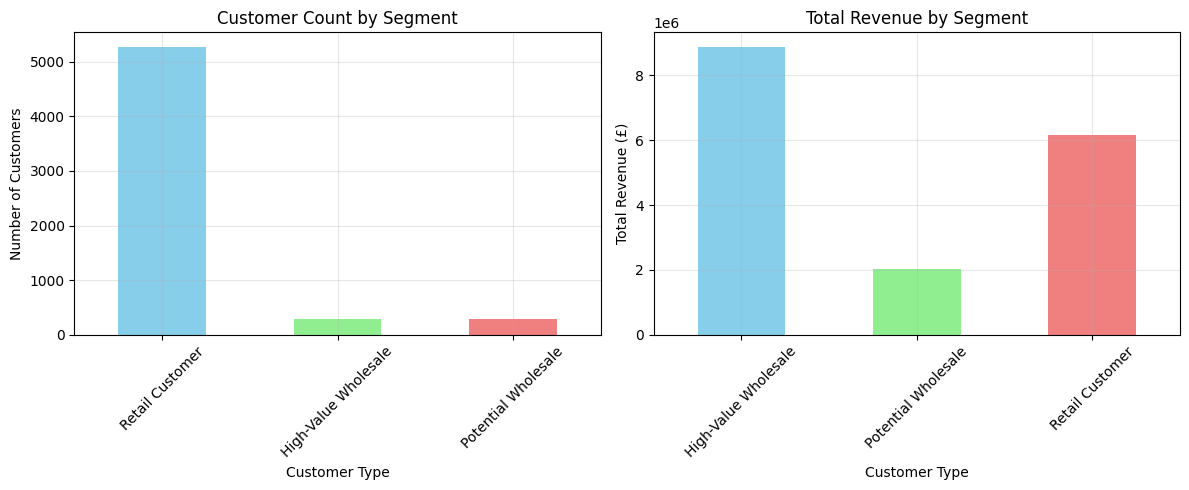

In [212]:
plt.figure(figsize=(12, 5))
    
# Subplot 1: Customer count by segment
plt.subplot(1, 2, 1)
segment_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Customer Count by Segment')
plt.xlabel('Customer Type')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
    
# Subplot 2: Revenue by segment
plt.subplot(1, 2, 2)
revenue_by_segment = segmented_df.groupby('Customer_Type')['Monetary'].sum()
revenue_by_segment.plot(kind='bar', color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Total Revenue by Segment')
plt.xlabel('Customer Type')
plt.ylabel('Total Revenue (£)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()

### Segment Revenue Insights:

* **Revenue by Segment**: The revenue generated by each segment is plotted, and we show the contribution percentage of each segment to the total revenue.

In [213]:
for segment in revenue_by_segment.index:
    revenue = revenue_by_segment[segment]
    percentage = (revenue / segmented_df['Monetary'].sum()) * 100
    print(f"{segment}: £{revenue:,.2f} ({percentage:.1f}% of total revenue)")

High-Value Wholesale: £8,884,048.00 (52.0% of total revenue)
Potential Wholesale: £2,029,487.88 (11.9% of total revenue)
Retail Customer: £6,159,940.00 (36.1% of total revenue)


# Phase 5: Data Enrichment via API Integration
---

**Team:** Code Serpents

**Team Member:** K. Lahiru Chanaka

---

## Executive Summary

This notebook demonstrates advanced data acquisition skills by integrating external currency exchange data through API calls. The enrichment enhances the dataset for international financial reporting and regional pricing strategies.

## Objectives

1. **API Integration**: Connect to a free currency conversion API using requests library
2. **Data Enrichment**: Convert transaction values to USD and EUR for top transactions
3. **Business Value**: Demonstrate the practical application of external data integration for international business operations

---

### API Configuration and Helper Functions
---

We'll use 'ExchangeRate-API', a free currency conversion service. This section includes:

- API configuration
- Error handling functions
- Rate limiting to respect API limits

In [214]:
# ================================================================
# API Configuration and Helper Functions
# ================================================================

# API Configuration

API_BASE_URL = 'https://v6.exchangerate-api.com/v6/679cea4bfe60efe64fe59613/latest/'
BASE_CURRENCY = 'GBP'
TARGET_CURRENCIES = ['USD', 'EUR']

def fetch_exchange_rates(base_currency='GBP', retries=3, delay=1):
    url = f"{API_BASE_URL}{base_currency}"

    for attempt in range(retries):
        try:
            print(f"Fetching exchange rates (attempt {attempt + 1}/{retries})...")

            response = requests.get(url)
            response.raise_for_status()

            data = response.json()

            # Validate response structure
            if 'conversion_rates' in data and 'time_last_update_utc' in data:
                print(f"Successfully fetched rates.")
                return {
                    'date': data['time_last_update_utc'],
                    'base': base_currency,
                    'rates': data['conversion_rates']  # Use 'conversion_rates' instead of 'rates'
                }
            else:
                print("Unexpected API response format.")
                return None

        except requests.exceptions.RequestException as e:
            print(f"API request failed (attempt {attempt + 1}): {str(e)}")

            if attempt < retries - 1:
                print(f"Waiting {delay} seconds before retrying...")
                time.sleep(delay)
            else:
                print("Max retries exceeded. Exiting...")
                return None

        except json.JSONDecodeError as e:
            print(f"JSON decode error: {str(e)}")
            return None

    return None

def convert_currency(amount, from_currency, to_currency, exchange_rates):
    try:
        if from_currency == to_currency:
            return amount

        if to_currency in exchange_rates['rates']:
            converted_amount = amount * exchange_rates['rates'][to_currency]
            return round(converted_amount, 2)
        else:
            print(f"Exchange rate for {to_currency} not found in the API response.")
            return None

    except (KeyError, TypeError, ValueError) as e:
        print(f"Currency conversion error: {str(e)}")
        return None

### 5.1 Identify the Top 100 Transactions
---

We retrieve the top 100 transactions based on the **TotalPrice** value, and analyze key statistics for these transactions.

In [215]:
top_100_transactions = df_clean.nlargest(100, 'TotalPrice').copy()

print("Top 100 Transactions Analysis:")
print(f"   - Highest transaction value: £{top_100_transactions['TotalPrice'].max():.2f}")
print(f"   - Lowest transaction value in top 100: £{top_100_transactions['TotalPrice'].min():.2f}")
print(f"   - Average transaction value: £{top_100_transactions['TotalPrice'].mean():.2f}")
print(f"   - Total value of top 100: £{top_100_transactions['TotalPrice'].sum():.2f}")

Top 100 Transactions Analysis:
   - Highest transaction value: £168469.59
   - Lowest transaction value in top 100: £2328.48
   - Average transaction value: £6209.15
   - Total value of top 100: £620914.75


### 5.2 Currency Conversion API Integration
---

We'll use 'ExchangeRate-API', a free currency conversion service. This section includes:

#### Fetch Current Exchange Rates

We fetch the latest exchange rates for **USD** and **EUR** against **GBP** and use fallback rates if the API request fails.

In [216]:
exchange_data = fetch_exchange_rates(BASE_CURRENCY)

if exchange_data:
    rates = exchange_data['rates']
    rate_date = exchange_data['date']

    print(f"Exchange rates fetched on {rate_date}.")
    print(f"Base currency: {BASE_CURRENCY}")

    for currency in TARGET_CURRENCIES:
        if currency in rates:
            print(f"Exchange rate for {currency}: {rates[currency]}")
        else:
            print(f"Exchange rate for {currency} not found in the API response.")

else:
    print("Failed to fetch exchange rates. Please check your API configuration or network connection.")

    # Fallback rates (approximate values)
    exchange_data = {
        'date': datetime.now().strftime('%Y-%m-%d'),
        'base': BASE_CURRENCY,
        'rates': {
            'USD': 1.25,
            'EUR': 1.15
        }
    }

    rates = exchange_data['rates']
    rate_date = exchange_data['date']

    print(f"Using fallback exchange rates for {rate_date}.")

    for currency in TARGET_CURRENCIES:
        print(f"Fallback exchange rate for {currency}: {rates[currency]}")

Fetching exchange rates (attempt 1/3)...
Successfully fetched rates.
Exchange rates fetched on Sat, 30 Aug 2025 00:00:02 +0000.
Base currency: GBP
Exchange rate for USD: 1.3497
Exchange rate for EUR: 1.155


### 5.3 Apply Currency Conversion to Top 100 Transactions
---

We convert the **TotalPrice** of the top 100 transactions from GBP to **USD** and **EUR** using the fetched exchange rates.

In [217]:
# Create a copy of the top 100 transactions for currency conversion
top_100_with_currency = top_100_transactions.copy()

# Add exchange rate information
top_100_with_currency['ExchangeRateDate'] = rate_date
top_100_with_currency['GBP_to_USD_Rate'] = rates.get('USD', None)
top_100_with_currency['GBP_to_EUR_Rate'] = rates.get('EUR', None)

# Convert TotalPrice to USD and EUR
print(f"Converting transaction values to multiple currencies...")

# USD Conversion
if 'USD' in rates:
    top_100_with_currency['TotalPrice_USD'] = top_100_with_currency['TotalPrice'].apply(
        lambda x: convert_currency(x, 'GBP', 'USD', exchange_data)
    )
    print(f"Successfully converted TotalPrice to USD.")

else:
    top_100_with_currency['TotalPrice_USD'] = None
    print("Exchange rate for USD not found in the API response.")

# EUR Conversion
if 'EUR' in rates:
    top_100_with_currency['TotalPrice_EUR'] = top_100_with_currency['TotalPrice'].apply(
        lambda x: convert_currency(x, 'GBP', 'EUR', exchange_data)
    )
    print(f"Successfully converted TotalPrice to EUR.")

else:
    top_100_with_currency['TotalPrice_EUR'] = None
    print("Exchange rate for EUR not found in the API response.")

# Display conversion summary
print(f"Currency Conversion Summary:")
print(f"    - Original GBP total: £{top_100_with_currency['TotalPrice'].sum():.2f}")

if top_100_with_currency['TotalPrice_USD'].notna().any():
    usd_total = top_100_with_currency['TotalPrice_USD'].sum()
    print(f"    - Converted USD total: ${usd_total:.2f}")

if top_100_with_currency['TotalPrice_EUR'].notna().any():
    eur_total = top_100_with_currency['TotalPrice_EUR'].sum()
    print(f"    - Converted EUR total: €{eur_total:.2f}")

Converting transaction values to multiple currencies...
Successfully converted TotalPrice to USD.
Successfully converted TotalPrice to EUR.
Currency Conversion Summary:
    - Original GBP total: £620914.75
    - Converted USD total: $838048.53
    - Converted EUR total: €717156.52


### 5.4 Data Validation and Quality Checks
---

It's important to validate our currency conversion results to ensure accuracy and identify any potential issues.

In [218]:
# Check for any conversion failures
usd_failures = top_100_with_currency['TotalPrice_USD'].isna().sum()
eur_failures = top_100_with_currency['TotalPrice_EUR'].isna().sum()
total_transactions = len(top_100_with_currency)

print(f"Convertion Quality Report:")
print(f"    - Total transactional processed: {total_transactions}")
print(f"    - USD conversion failures: {usd_failures}")
print(f"    - EUR conversion failures: {eur_failures}")
print(f"    - Success rate: {(total_transactions - usd_failures - eur_failures) / total_transactions * 100:.2f}%")

# Check if any values that might indicate errors
if top_100_with_currency['TotalPrice_USD'].notna().any():
    usd_values = top_100_with_currency['TotalPrice_USD'].dropna()
    usd_mean = usd_values.mean()
    usd_std = usd_values.std()
    outliers_usd = usd_values[(usd_values > usd_mean + 3 * usd_std) | (usd_values < usd_mean - 3 * usd_std)]
    print(f"    - USD outliers found: {len(outliers_usd)}")

if top_100_with_currency['TotalPrice_EUR'].notna().any():
    eur_values = top_100_with_currency['TotalPrice_EUR'].dropna()
    eur_mean = eur_values.mean()
    eur_std = eur_values.std()
    outliers_eur = eur_values[(eur_values > eur_mean + 3 * eur_std) | (eur_values < eur_mean - 3 * eur_std)]
    print(f"    - EUR outliers found: {len(outliers_eur)}")

print()
print("Data validation completed")

Convertion Quality Report:
    - Total transactional processed: 100
    - USD conversion failures: 0
    - EUR conversion failures: 0
    - Success rate: 100.00%
    - USD outliers found: 2
    - EUR outliers found: 2

Data validation completed


### 5.5 Display Top 10 Transactions with Currency Conversion
---

We display the top 10 transactions with **GBP**, **USD**, and **EUR** values formatted for easy readability.

In [219]:
# Display the top 10 transactions for demonstration purposes
print("Top 10 Transactions with Currency Conversion:")
print("=" * 50)

display_columns = ['Invoice', 'TotalPrice', 'TotalPrice_USD', 'TotalPrice_EUR']

if 'Country' in top_100_with_currency.columns:
    display_columns.insert(1, 'Country')

if 'InvoiceDate' in top_100_with_currency.columns:
    display_columns.insert(1, 'InvoiceDate')

# Select the top 10 transactions
top_10_display = top_100_with_currency[display_columns].head(10).copy()

# Format the currency columns for better readability
if 'TotalPrice' in top_10_display.columns:
    top_10_display['TotalPrice_GBP'] = top_10_display['TotalPrice'].apply(lambda x: f"£{x:.2f}")

if 'TotalPrice_USD' in top_10_display.columns:
    top_10_display['TotalPrice_USD_formatted'] = top_10_display['TotalPrice_USD'].apply(lambda x: f"${x:.2f}" if pd.notna(x) else "N/A")

if 'TotalPrice_EUR' in top_10_display.columns:
    top_10_display['TotalPrice_EUR_formatted'] = top_10_display['TotalPrice_EUR'].apply(lambda x: f"€{x:.2f}" if pd.notna(x) else "N/A")

# Display formatted results
print(top_10_display[['Invoice', 'TotalPrice_GBP', 'TotalPrice_USD_formatted', 'TotalPrice_EUR_formatted']].to_string(index=False))

Top 10 Transactions with Currency Conversion:
Invoice TotalPrice_GBP TotalPrice_USD_formatted TotalPrice_EUR_formatted
 581483     £168469.59               $227383.41               €194582.38
 541431      £77183.60               $104174.71                €89147.06
 556444      £38970.00                $52597.81                €45010.35
 530715      £15818.40                $21350.10                €18270.25
 511465       £8925.00                $12046.07                €10308.38
 567423       £7144.72                 $9643.23                 €8252.15
 540815       £6539.40                 $8826.23                 €7553.01
 550461       £6539.40                 $8826.23                 €7553.01
 525968       £5179.20                 $6990.37                 €5981.98
 573003       £4992.00                 $6737.70                 €5765.76


### 5.6 Statistical Summary and Comparison
---

We generate summary statistics for the transactions in **GBP**, **USD**, and **EUR**.

In [220]:
# Generate summary statistics
print("Statistical Summary Across Currencies:")
print("=" * 50)

# Calculate statistics for each currency
currencies = ['GBP', 'USD', 'EUR']
currency_columns = ['TotalPrice', 'TotalPrice_USD', 'TotalPrice_EUR']
currency_symbols = ['£', '$', '€']

stats_summary = {}

for currency, column, symbol in zip(currencies, currency_columns, currency_symbols):
    if column in top_100_with_currency.columns:
        values = top_100_with_currency[column].dropna()

        if not values.empty:
            stats_summary[currency] = {
                'count': len(values),
                'mean': values.mean(),
                'median': values.median(),
                'std': values.std(),
                'min': values.min(),
                'max': values.max(),
                'total': values.sum(),
                'symbol': symbol
            }

# Display formatted table
if stats_summary:
    print(f"{'Metric':<10} {'GBP':<15} {'USD':<15} {'EUR':<15}")
    print("-" * 55)

    metrics = ['count', 'mean', 'median', 'std', 'min', 'max', 'total']
    metric_names = ['Count', 'Mean', 'Median', 'Std Dev', 'Minimum', 'Maximum', 'Total']

    for metric, name in zip(metrics, metric_names):
        row = f"{name:<10}"

        for currency in currencies:
            if currency in stats_summary:
                if metric == 'count':
                    value = f"{stats_summary[currency][metric]}"
                else:
                    symbol = stats_summary[currency]['symbol']
                    value = f"{symbol}{stats_summary[currency][metric]:,.2f}"

                row += f" {value:<15}"

            else:
                row += f" {'N/A':<15}"

        print(row)

Statistical Summary Across Currencies:
Metric     GBP             USD             EUR            
-------------------------------------------------------
Count      100             100             100            
Mean       £6,209.15       $8,380.49       €7,171.57      
Median     £3,172.28       $4,281.62       €3,663.98      
Std Dev    £18,376.99      $24,803.43      €21,225.43     
Minimum    £2,328.48       $3,142.75       €2,689.39      
Maximum    £168,469.59     $227,383.41     €194,582.38    
Total      £620,914.75     $838,048.53     €717,156.52    


### 5.7 Visualization of Currency Conversions
---

We create various visualizations to compare currency distributions, segment-wise revenue, and exchange rates.

### Currency Comparison Visualizations:

1. **Transaction Value Distribution by Currency**: Boxplots comparing transaction values across **GBP**, **USD**, and **EUR**.
2. **Top 10 Transactions Comparison**: Bar charts showing the top 10 transactions in different currencies.
3. **Exchange Rates Visualization**: A bar chart showing the exchange rates for **GBP** to **USD** and **EUR**.
4. **Currency Conversion Summary**: Pie chart showing the total value distribution across currencies.

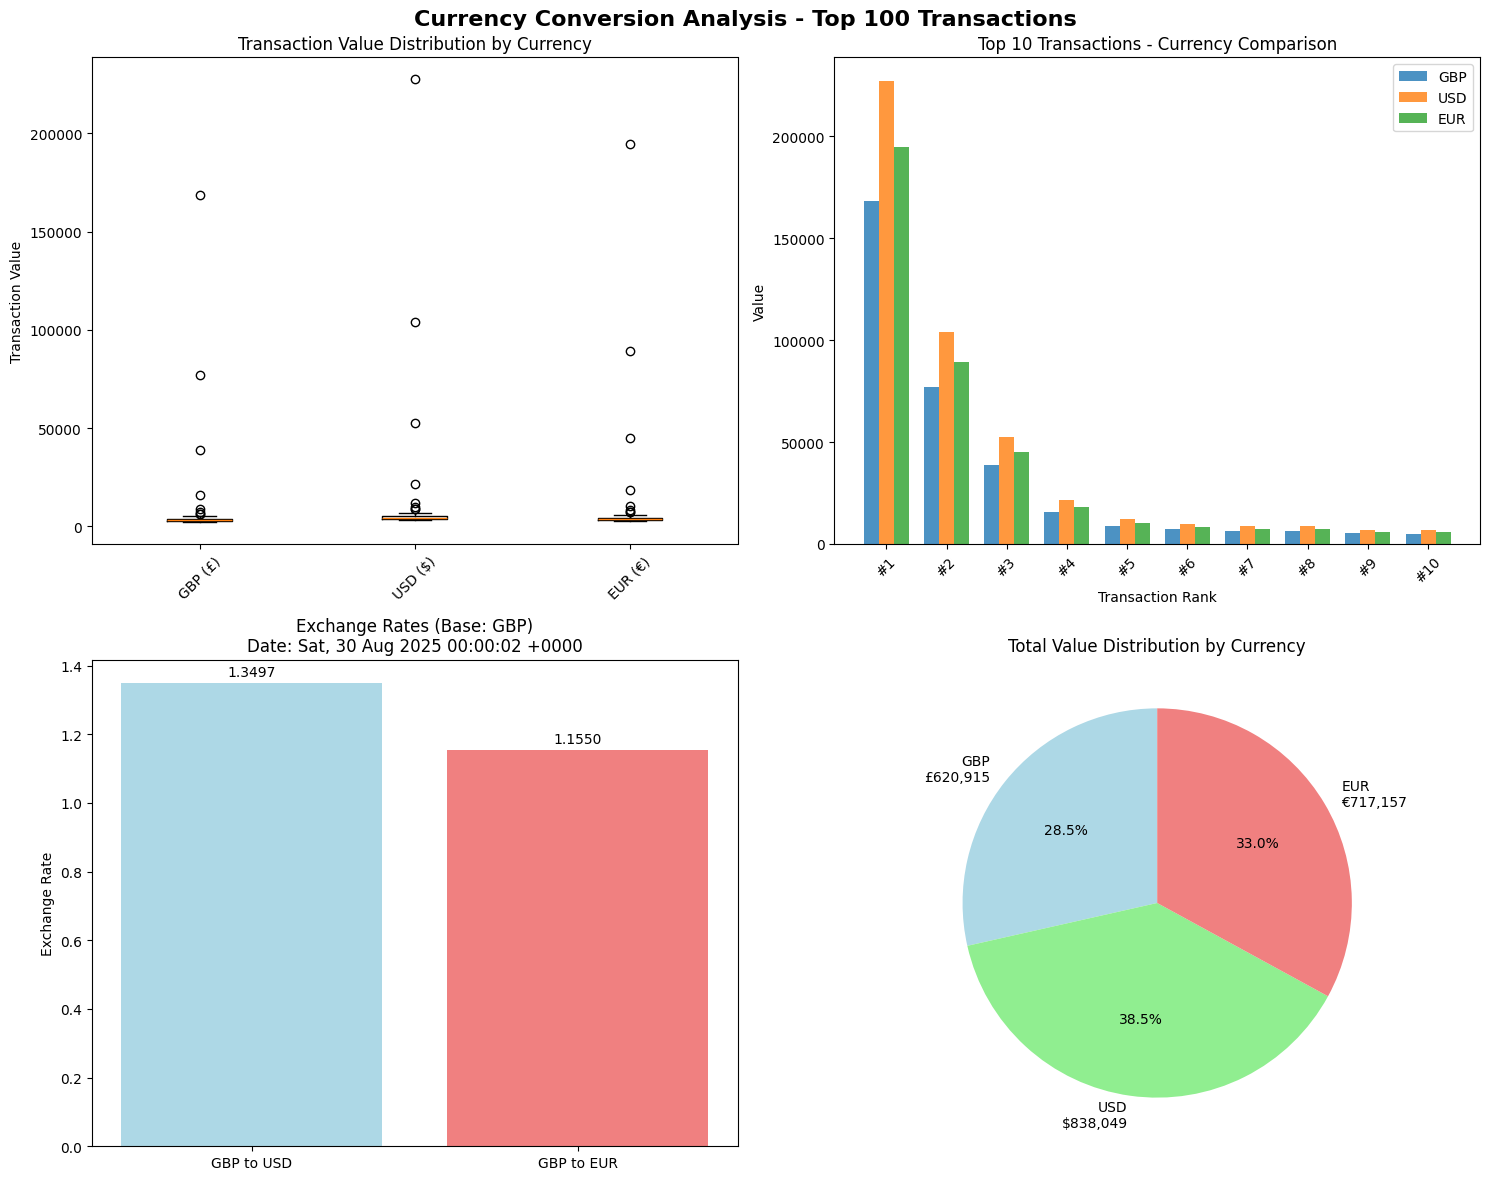

In [221]:
# Create visualizations for currency comparison
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15,12))
fig.suptitle('Currency Conversion Analysis - Top 100 Transactions', fontsize=16, fontweight='bold')

# 1. Compare of transaction values across currencies
ax1 = axes[0, 0]
currency_data = []
currency_labels = []

if 'TotalPrice' in top_100_with_currency.columns:
    currency_data.append(top_100_with_currency['TotalPrice'].dropna())
    currency_labels.append('GBP (£)')

if 'TotalPrice_USD' in top_100_with_currency.columns:
    usd_data = top_100_with_currency['TotalPrice_USD'].dropna()

    if not usd_data.empty:
        currency_data.append(usd_data)
        currency_labels.append('USD ($)')

if 'TotalPrice_EUR' in top_100_with_currency.columns:
    eur_data = top_100_with_currency['TotalPrice_EUR'].dropna()

    if not eur_data.empty:
        currency_data.append(eur_data)
        currency_labels.append('EUR (€)')

if currency_data:
    ax1.boxplot(currency_data, labels=currency_labels)
    ax1.set_title('Transaction Value Distribution by Currency')
    ax1.set_ylabel('Transaction Value')
    ax1.tick_params(axis='x', rotation=45)
else:
    ax1.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax1.transAxes)
    ax1.set_title('Transaction Value Distribution - No Data')

# 2. Top 10 transactions comparison
ax2 = axes[0, 1]
top_10 = top_100_with_currency.head(10)
x_pos = np.arange(len(top_10))

if not top_10.empty:
    width = 0.25

    if 'TotalPrice' in top_10.columns:
        ax2.bar(x_pos - width, top_10['TotalPrice'], width, label='GBP', alpha=0.8)

    if 'TotalPrice_USD' in top_10.columns and top_10['TotalPrice_USD'].notna().any():
        ax2.bar(x_pos, top_10['TotalPrice_USD'], width, label='USD', alpha=0.8)

    if 'TotalPrice_EUR' in top_10.columns and top_10['TotalPrice_EUR'].notna().any():
        ax2.bar(x_pos + width, top_10['TotalPrice_EUR'], width, label='EUR', alpha=0.8)

    ax2.set_title('Top 10 Transactions - Currency Comparison')
    ax2.set_xlabel('Transaction Rank')
    ax2.set_ylabel('Value')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f'#{i+1}' for i in range(len(top_10))])
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)

else:
    ax2.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Top 10 Transactions - No Data')

# 3. Exchange rate visualization
ax3 = axes[1, 0]

if rates:
    rate_currencies = []
    rate_values = []

    for currency in TARGET_CURRENCIES:
        if currency in rates:
            rate_currencies.append(f'GBP to {currency}')
            rate_values.append(rates[currency])

    if rate_currencies:
        bars = ax3.bar(rate_currencies, rate_values, color=['lightblue', 'lightcoral'])
        ax3.set_title(f'Exchange Rates (Base: GBP)\nDate: {rate_date}')
        ax3.set_ylabel('Exchange Rate')

        # Add value labels to bars
        for bar, value in zip(bars, rate_values):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                     f'{value:.4f}', ha='center', va='bottom')

    else:
        ax3.text(0.5, 0.5, 'No exchange rates available', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Exchange Rates - No Data')

else:
    ax3.text(0.5, 0.5, 'No exchange rates available', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Exchange Rates - No Data')

# 4. Currency conversion summary pie chart
ax4 = axes[1, 1]

if stats_summary:
    total_values = [stats_summary[currency]['total'] for currency in currencies if currency in stats_summary]
    total_labels = [f"{currency}\n{stats_summary[currency]['symbol']}{stats_summary[currency]['total']:,.0f}"
                   for currency in currencies if currency in stats_summary]

    if total_values:
        colors = ['lightblue', 'lightgreen', 'lightcoral']
        ax4.pie(total_values, labels=total_labels, autopct='%1.1f%%',
               colors=colors[:len(total_values)], startangle=90)
        ax4.set_title('Total Value Distribution by Currency')

    else:
        ax4.text(0.5, 0.5, 'No data for pie chart', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Total Value Distribution - No Data')

else:
    ax4.text(0.5, 0.5, 'No data for pie chart', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Total Value Distribution - No Data')

plt.tight_layout()
plt.show()

# 1. boxplot
fig1, ax1 = plt.subplots(figsize=(8, 6))
if currency_data:
    ax1.boxplot(currency_data, labels=currency_labels)
    ax1.set_title('Transaction Value Distribution by Currency')
    ax1.set_ylabel('Transaction Value')
    ax1.tick_params(axis='x', rotation=45)
plt.close(fig1)

# 2. top 10 transactions chart
fig2, ax2 = plt.subplots(figsize=(10, 6))
if not top_10.empty:
    width = 0.25
    if 'TotalPrice' in top_10.columns:
        ax2.bar(x_pos - width, top_10['TotalPrice'], width, label='GBP', alpha=0.8)
    if 'TotalPrice_USD' in top_10.columns and top_10['TotalPrice_USD'].notna().any():
        ax2.bar(x_pos, top_10['TotalPrice_USD'], width, label='USD', alpha=0.8)
    if 'TotalPrice_EUR' in top_10.columns and top_10['TotalPrice_EUR'].notna().any():
        ax2.bar(x_pos + width, top_10['TotalPrice_EUR'], width, label='EUR', alpha=0.8)
    
    ax2.set_title('Top 10 Transactions - Currency Comparison')
    ax2.set_xlabel('Transaction Rank')
    ax2.set_ylabel('Value')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f'#{i+1}' for i in range(len(top_10))])
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)
plt.close(fig2)

# 3.  exchange rates chart
fig3, ax3 = plt.subplots(figsize=(8, 6))
if rates:
    rate_currencies = []
    rate_values = []
    for currency in TARGET_CURRENCIES:
        if currency in rates:
            rate_currencies.append(f'GBP to {currency}')
            rate_values.append(rates[currency])
    
    if rate_currencies:
        bars = ax3.bar(rate_currencies, rate_values, color=['lightblue', 'lightcoral'])
        ax3.set_title(f'Exchange Rates (Base: GBP)\nDate: {rate_date}')
        ax3.set_ylabel('Exchange Rate')
        for bar, value in zip(bars, rate_values):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                     f'{value:.4f}', ha='center', va='bottom')
plt.close(fig3)

# 4. pie chart
fig4, ax4 = plt.subplots(figsize=(8, 6))
if stats_summary:
    total_values = [stats_summary[currency]['total'] for currency in currencies if currency in stats_summary]
    total_labels = [f"{currency}\n{stats_summary[currency]['symbol']}{stats_summary[currency]['total']:,.0f}"
                   for currency in currencies if currency in stats_summary]
    
    if total_values:
        colors = ['lightblue', 'lightgreen', 'lightcoral']
        ax4.pie(total_values, labels=total_labels, autopct='%1.1f%%',
               colors=colors[:len(total_values)], startangle=90)
        ax4.set_title('Total Value Distribution by Currency')
plt.close(fig4)